<a href="https://colab.research.google.com/github/dtabuena/2HG/blob/main/Schaffer/Schaffer_Pipeline_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
!python -V

Python 3.11.4


In [152]:
!pip install pyABF --quiet

In [153]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sci
import os
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
import urllib
import pyabf
import statsmodels.api as sm  # For weighted least squares
import re


import scipy.signal
import scipy.ndimage
import statsmodels.api as sm
import scipy.ndimage

import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import zscore

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [154]:
workspace_dir = r'C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi'
import urllib
response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py

In [155]:
def read_ch4_epochs(abf_rec,pad_x=True):
    header_html = abf_rec.headerHTML
    patterns = {"fEpochInitLevel": r"fEpochInitLevel = <code>\[(.*?)\]</code>",
                "fEpochLevelInc": r"fEpochLevelInc = <code>\[(.*?)\]</code>",
                "lEpochDurationInc": r"lEpochDurationInc = <code>\[(.*?)\]</code>",
                "lEpochInitDuration": r"lEpochInitDuration = <code>\[(.*?)\]</code>",}
    ch4_epochs = {}
    for key, pattern in patterns.items():
        match = re.findall(pattern, header_html)
        if match:
            ch4_epochs[key] = [float(i) if '.' in i else int(i) for i in match[0].split(',')]
    if pad_x:
        x_len = len(abf_rec.sweepX)
        holding_pct = int(x_len*.015)
        ep_len = np.sum(ch4_epochs['lEpochInitDuration'])
        delta = x_len - ep_len - holding_pct
        ch4_epochs["fEpochInitLevel"].append(0.0)
        ch4_epochs["fEpochLevelInc"].append(0.0)
        ch4_epochs["lEpochDurationInc"].append(0)
        ch4_epochs["lEpochInitDuration"].append(delta)
        ch4_epochs["fEpochInitLevel"] = [0] + ch4_epochs["fEpochInitLevel"]
        ch4_epochs["fEpochLevelInc"] = [0] + ch4_epochs["fEpochLevelInc"]
        ch4_epochs["lEpochDurationInc"] = [0] + ch4_epochs["lEpochDurationInc"]
        ch4_epochs["lEpochInitDuration"] = [holding_pct] + ch4_epochs["lEpochInitDuration"]
    return ch4_epochs




In [156]:
def record_figs(abf_rec,fig_obj,tag=None,dir='analysis_figs'):
    rec_name = os.path.basename(abf_rec.abfFilePath).replace('.abf',"")
    os.makedirs(dir,exist_ok=True)
    if tag is None:
        tag = abf_rec.protocol
    fig_obj.savefig(f'./{dir}/{tag}_{rec_name}.jpg')

In [157]:

def build_epoch_trace(ch4_epochs,abf_rec):
    fs = abf_rec.sampleRate
    epoch_waveforms = []
    for s in abf_rec.sweepList:
        wave = []
        for ep in range(len(ch4_epochs['fEpochInitLevel'])):
            x_dur = ch4_epochs['lEpochInitDuration'][ep] + s*ch4_epochs['lEpochDurationInc'][ep]
            y_lev = ch4_epochs['fEpochInitLevel'][ep] + s*ch4_epochs['fEpochLevelInc'][ep]
            wave.append( np.ones(x_dur) * y_lev)
        wave=np.concatenate(wave,0)
        epoch_waveforms.append(wave)
    ep_time = np.arange(len(wave))/fs
    return epoch_waveforms,ep_time

In [158]:

#### VALID ####


def analyze_lfp_wash_in(abf_rec, switch_time, control_time=10, wash_delta=1.5, avg_last_minutes=5, to_plot=True):
    """
    Analyzes LFP responses across multiple sweeps in an ABF recording, normalizing relative to a baseline period,
    computing Pop:EPSP ratio, and determining the fold change over time.

    Parameters:
        abf_rec: pyABF.ABF object
        switch_time: float, time at which the wash-in starts
        control_time: float, time window (in minutes) before switch_time for baseline normalization
        wash_delta: float, adjustment time to align data properly (default = 1.5 min)
        avg_last_minutes: float, time window (in minutes) at the end of the recording to compute fold shift
        to_plot: bool, whether to generate plots

    Returns:
        final_fold_shift: dict containing final normalized Pop Spike, EPSP slopes, and Pop:EPSP ratio after wash-in
        results: dict containing all raw and processed data for reference
    """

    switch_time += wash_delta  # Adjust switch time
    ch4_epochs = read_ch4_epochs(abf_rec)
    epoch_waveforms, ep_time = build_epoch_trace(ch4_epochs, abf_rec)

    epsp_list = []
    pop_list = []
    stim_list = []

    for swp in abf_rec.sweepList:
        abf_rec.setSweep(swp, 0)  # Set to channel 0 (POP spike)
        stim = epoch_waveforms[swp]
        time = abf_rec.sweepX
        resp_pop = abf_rec.sweepY

        # Find stimulus trigger
        trig_ind = np.argmax(stim)

        # Define analysis window: trig -5ms to trig +20ms
        w_start, w_end = int(trig_ind - 0.005 / (time[1] - time[0])), int(trig_ind + 0.020 / (time[1] - time[0]))

        if w_start < 0 or w_end > len(time):
            print(f"Warning: Skipping sweep {swp} due to out-of-bounds clipping.")
            continue

        # Clip data
        clipped_time = time[w_start:w_end] - time[trig_ind]  # Normalize time
        clipped_stim = stim[w_start:w_end]
        clipped_pop = resp_pop[w_start:w_end]

        # Compute Pop Spike Amplitude
        pop_amp, stim_amp = pop_spike(clipped_time, clipped_stim, clipped_pop, to_plot=(swp == 1))

        abf_rec.setSweep(swp, 1)  # Set to channel 1 (EPSP)
        resp_epsp = abf_rec.sweepY
        clipped_epsp = resp_epsp[w_start:w_end]

        # Compute EPSP Slope
        epsp_slope, _ = EPSP_slope(clipped_time, clipped_stim, clipped_epsp, to_plot=(swp == 1))

        if np.isnan(pop_amp) or np.isnan(epsp_slope) or epsp_slope == 0:
            continue  # Skip invalid results

        pop_list.append(pop_amp)
        epsp_list.append(epsp_slope)
        stim_list.append(stim_amp)

    # Convert lists to NumPy arrays
    pop_arr = np.array(pop_list, dtype=np.float64)
    epsp_arr = np.array(epsp_list, dtype=np.float64)
    stim_arr = np.array(stim_list, dtype=np.float64)

    # Compute raw Pop:EPSP ratio
    pop_epsp_ratio = pop_arr / epsp_arr

    # Compute control indices (baseline window)
    control_inds = np.logical_and(
        abf_rec.sweepTimesMin > switch_time - control_time,
        abf_rec.sweepTimesMin < switch_time
    )

    rel_sweep_time = abf_rec.sweepTimesMin - switch_time  # Compute relative wash-in time

    # Baseline normalization
    epsp_baseline = np.mean(epsp_arr[control_inds])
    pop_baseline = np.mean(pop_arr[control_inds])
    pop_epsp_baseline = np.mean(pop_epsp_ratio[control_inds])

    norm_pop_arr = pop_arr / pop_baseline
    norm_epsp_arr = epsp_arr / epsp_baseline
    norm_pop_epsp_ratio = pop_epsp_ratio  / pop_epsp_baseline

    # Apply moving average filter
    window_size = 7
    smoothed_pop = scipy.ndimage.uniform_filter1d(norm_pop_arr, size=window_size, mode='reflect')
    smoothed_epsp = scipy.ndimage.uniform_filter1d(norm_epsp_arr, size=window_size, mode='reflect')
    smoothed_pop_epsp_ratio = scipy.ndimage.uniform_filter1d(norm_pop_epsp_ratio, size=window_size, mode='reflect')

    # Compute final fold shift using the last `avg_last_minutes` of the recording
    last_inds = rel_sweep_time >= (rel_sweep_time.max() - avg_last_minutes)
    final_pop_shift = np.mean(norm_pop_arr[last_inds])
    final_epsp_shift = np.mean(norm_epsp_arr[last_inds])
    final_pop_epsp_shift = np.mean(norm_pop_epsp_ratio[last_inds])

    final_fold_shift = {
        "final_pop_spike_fold_shift": final_pop_shift,
        "final_epsp_slope_fold_shift": final_epsp_shift,
        "final_pop_epsp_ratio_fold_shift": final_pop_epsp_shift
    }

    if to_plot:
        fig, ax = plt.subplots(3, 1, figsize=(3, 3))

        # Plot normalized Pop Spike response
        ax[0].scatter(rel_sweep_time, norm_pop_arr, color='k')
        ax[0].plot(rel_sweep_time, smoothed_pop, color='k')
        ax[0].axvline(0, color='r')
        ax[0].axhline(1, color='k', linestyle="--")
        ax[0].set_ylim([0.5, np.max(norm_pop_arr) * 1.1])
        ax[0].set_ylabel('Rel Pop. Change')

        # Plot normalized EPSP response
        ax[1].scatter(rel_sweep_time, norm_epsp_arr, color='k')
        ax[1].plot(rel_sweep_time, smoothed_epsp, color='k')
        ax[1].axvline(0, color='r')
        ax[1].axhline(1, color='k', linestyle="--")
        ax[1].set_ylim([0.5, np.max(norm_epsp_arr) * 1.1])
        ax[1].set_ylabel('Rel EPSP Change')

        # Plot normalized Pop:EPSP ratio
        ax[2].scatter(rel_sweep_time, norm_pop_epsp_ratio, color='k')
        ax[2].plot(rel_sweep_time, smoothed_pop_epsp_ratio, color='k')
        ax[2].axvline(0, color='r')
        ax[2].axhline(1, color='k', linestyle="--")
        ax[2].set_ylim([0.5, np.max(norm_pop_epsp_ratio) * 1.1])
        ax[2].set_ylabel('Rel Pop:EPSP Ratio')
        ax[2].set_xlabel('HMGB1 Wash-in Time (min)')

        plt.tight_layout()
        plt.show()
        record_figs(abf,fig_obj)

    # Store all computed data
    results = {
        "relative_sweep_time": rel_sweep_time,
        "normalized_pop_spike": norm_pop_arr,
        "normalized_epsp_slope": norm_epsp_arr,
        "normalized_pop_epsp_ratio": norm_pop_epsp_ratio,
        "smoothed_pop_spike": smoothed_pop,
        "smoothed_epsp_slope": smoothed_epsp,
        "smoothed_pop_epsp_ratio": smoothed_pop_epsp_ratio
    }

    result_dict = {'final_fold_shift':final_fold_shift,"sweep_results":results}
    return result_dict


In [159]:
import numpy as np
import scipy.ndimage
import statsmodels.api as sm
import matplotlib.pyplot as plt

def analyze_lfp_wash_in_rdc(abf_rec, switch_time, control_time=10, wash_delta=1.5, avg_last_minutes=5, rdc=True, alpha=0.25, to_plot=True):
    """
    Analyzes LFP responses across multiple sweeps in an ABF recording, normalizing relative to a baseline period,
    computing Pop:EPSP ratio, and determining the fold change over time with optional rundown correction.

    Parameters:
        abf_rec: pyABF.ABF object
        switch_time: float, time at which the wash-in starts
        control_time: float, time window (in minutes) before switch_time for baseline normalization
        wash_delta: float, adjustment time to align data properly (default = 1.5 min)
        avg_last_minutes: float, time window (in minutes) at the end of the recording to compute fold shift
        rdc: bool, whether to apply rundown correction (default = True)
        alpha: float, strength of the rundown correction (1 = full correction, 0 = no correction)
        to_plot: bool, whether to generate plots

    Returns:
        final_fold_shift: dict containing final normalized Pop Spike, EPSP slopes, and Pop:EPSP ratio after wash-in
        results: dict containing all raw and processed data for reference
    """

    switch_time += wash_delta  # Adjust switch time
    ch4_epochs = read_ch4_epochs(abf_rec)
    epoch_waveforms, ep_time = build_epoch_trace(ch4_epochs, abf_rec)

    epsp_list = []
    pop_list = []
    stim_list = []

    for swp in abf_rec.sweepList:
        abf_rec.setSweep(swp, 0)
        stim = epoch_waveforms[swp]
        time = abf_rec.sweepX
        resp_pop = abf_rec.sweepY

        trig_ind = np.argmax(stim)
        w_start, w_end = int(trig_ind - 0.005 / (time[1] - time[0])), int(trig_ind + 0.020 / (time[1] - time[0]))

        if w_start < 0 or w_end > len(time):
            continue

        clipped_time = time[w_start:w_end] - time[trig_ind]
        clipped_stim = stim[w_start:w_end]
        clipped_pop = resp_pop[w_start:w_end]

        pop_amp, stim_amp = pop_spike(clipped_time, clipped_stim, clipped_pop, to_plot=False)

        abf_rec.setSweep(swp, 1)
        resp_epsp = abf_rec.sweepY
        clipped_epsp = resp_epsp[w_start:w_end]

        epsp_slope, _ = EPSP_slope(clipped_time, clipped_stim, clipped_epsp, to_plot=False)

        if np.isnan(pop_amp) or np.isnan(epsp_slope) or epsp_slope == 0:
            continue

        pop_list.append(pop_amp)
        epsp_list.append(epsp_slope)
        stim_list.append(stim_amp)

    pop_arr = np.array(pop_list, dtype=np.float64)
    epsp_arr = np.array(epsp_list, dtype=np.float64)
    pop_epsp_ratio = pop_arr / epsp_arr

    control_inds = np.logical_and(
        abf_rec.sweepTimesMin > switch_time - control_time,
        abf_rec.sweepTimesMin < switch_time
    )

    rel_sweep_time = abf_rec.sweepTimesMin - switch_time

    # **Normalize all values relative to baseline**
    epsp_baseline = np.mean(epsp_arr[control_inds])
    pop_baseline = np.mean(pop_arr[control_inds])
    pop_epsp_baseline = np.mean(pop_epsp_ratio[control_inds])

    norm_pop_arr = pop_arr / pop_baseline
    norm_epsp_arr = epsp_arr / epsp_baseline
    norm_pop_epsp_ratio = pop_epsp_ratio / pop_epsp_baseline

    if rdc:
        # **Apply rundown correction ONLY to Pop Spike and EPSP Slope**
        control_times = abf_rec.sweepTimesMin[control_inds]
        X_control = sm.add_constant(control_times)

        pop_model = sm.OLS(norm_pop_arr[control_inds], X_control).fit()
        epsp_model = sm.OLS(norm_epsp_arr[control_inds], X_control).fit()

        X_all = sm.add_constant(abf_rec.sweepTimesMin)

        # **Compute unscaled predicted fits**
        pop_pred_full = pop_model.predict(X_all)
        epsp_pred_full = epsp_model.predict(X_all)

        # **Ensure fit goes through control mean**
        pop_control_mean = np.mean(norm_pop_arr[control_inds])
        epsp_control_mean = np.mean(norm_epsp_arr[control_inds])

        pop_pred = pop_control_mean + alpha * (pop_pred_full - pop_control_mean)
        epsp_pred = epsp_control_mean + alpha * (epsp_pred_full - epsp_control_mean)

        norm_pop_arr_corrected = norm_pop_arr / pop_pred
        norm_epsp_arr_corrected = norm_epsp_arr / epsp_pred
    else:
        norm_pop_arr_corrected = norm_pop_arr
        norm_epsp_arr_corrected = norm_epsp_arr

    last_inds = rel_sweep_time >= (rel_sweep_time.max() - avg_last_minutes)
    final_pop_shift = np.mean(norm_pop_arr_corrected[last_inds])
    final_epsp_shift = np.mean(norm_epsp_arr_corrected[last_inds])
    final_pop_epsp_shift = np.mean(norm_pop_epsp_ratio[last_inds])

    final_fold_shift = {
        "final_pop_spike_fold_shift": final_pop_shift,
        "final_epsp_slope_fold_shift": final_epsp_shift,
        "final_pop_epsp_ratio_fold_shift": final_pop_epsp_shift
    }

    # **Store all processed results**
    results = {
        "relative_sweep_time": rel_sweep_time,
        "normalized_pop_spike": norm_pop_arr_corrected,
        "normalized_epsp_slope": norm_epsp_arr_corrected,
        "normalized_pop_epsp_ratio": norm_pop_epsp_ratio  # **Uncorrected Ratio**
    }

    if to_plot:
        fig, ax = plt.subplots(3, 1, figsize=(3, 3))  # **Final Figure Size**

        # **Plot Pop Spike and EPSP with RDC applied**
        for i, (raw, corrected, pred, ylabel) in enumerate(zip(
            [norm_pop_arr, norm_epsp_arr],
            [norm_pop_arr_corrected, norm_epsp_arr_corrected],
            [pop_pred, epsp_pred],
            ['Rel Pop. Change', 'Rel EPSP Change']
        )):
            ax[i].scatter(rel_sweep_time, raw, color='k', s=2)
            ax[i].plot(rel_sweep_time, pred, color='m', linestyle="--", linewidth=0.5)
            ax[i].scatter(rel_sweep_time, corrected, color='c', alpha=0.7, s=2)
            ax[i].axvline(0, color='r', linewidth=0.5)
            ax[i].axhline(1, color='k', linestyle="--", linewidth=0.5)
            ax[i].set_ylabel(ylabel, fontsize=6)
            ax[i].tick_params(axis='both', which='major', labelsize=5)

        # **Plot Pop:EPSP Ratio (NO RDC)**
        ax[2].scatter(rel_sweep_time, norm_pop_epsp_ratio, color='k', s=2)
        ax[2].axvline(0, color='r', linewidth=0.5)
        ax[2].axhline(1, color='k', linestyle="--", linewidth=0.5)
        ax[2].set_ylabel('Rel Pop:EPSP Ratio', fontsize=6)
        ax[2].tick_params(axis='both', which='major', labelsize=5)

        ax[2].set_xlabel('Wash-in Time (min)', fontsize=6)
        plt.tight_layout()
        plt.show()
        record_figs(abf_rec,fig)

    return final_fold_shift, results


In [160]:
# file_name = r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\Slice_LFP_Data\David_HMGB1\2025x02x28_E4KI_F_P275_\2025x02x28_E4KI_F_P275_sagi_s001_0000.abf"
# abf_rec = pyabf.ABF(file_name)
# # analyze_lfp_wash_in_rdc(abf_rec,12.5,control_time=5,alpha=0.25)




In [161]:


# VALID ##


def analyze_ramp(abf_rec, to_plot=False, verbose=False):
    """
    Analyzes both EPSP slope and Population Spike amplitude in a single iteration over sweeps.

    Parameters:
        abf_rec: pyABF.ABF object
        to_plot: bool, whether to generate plots
        verbose: bool, whether to print debug information

    Returns:
        epsp_ramp_slope: float, computed slope of EPSP response vs. stimulus
        pop_ramp_slope: float, computed slope of Pop Spike response vs. stimulus
    """

    # Read stimulus waveforms
    ch4_epochs = read_ch4_epochs(abf_rec)
    epoch_waveforms, ep_time = build_epoch_trace(ch4_epochs, abf_rec)

    epsp_list, pop_list, stim_list = [], [], []

    for swp in abf_rec.sweepList:
        abf_rec.setSweep(swp, 0)  # Set channel to 0 (POP spike)
        stim = epoch_waveforms[swp]
        time = abf_rec.sweepX
        resp_pop = abf_rec.sweepY

        # Find stimulus trigger
        trig_ind = np.argmax(stim)  # Max stimulus point is the trigger

        # Define visualization window: trig - 5ms to trig + 20ms
        w_start, w_end = int(trig_ind - 0.005 / (time[1] - time[0])), int(trig_ind + 0.020 / (time[1] - time[0]))

        if w_start < 0 or w_end > len(time):
            print(f"Warning: Skipping sweep {swp} due to out-of-bounds clipping.")
            continue

        # Clip data
        clipped_time = time[w_start:w_end] - time[trig_ind]  # Normalize time
        clipped_stim = stim[w_start:w_end]
        clipped_pop = resp_pop[w_start:w_end]

        # Compute Pop Spike Amplitude
        pop_amp, stim_amp = pop_spike(clipped_time, clipped_stim, clipped_pop, to_plot=(swp == 1))

        abf_rec.setSweep(swp, 1)  # Set channel to 1 (EPSP)
        resp_epsp = abf_rec.sweepY
        clipped_epsp = resp_epsp[w_start:w_end]

        # Compute EPSP Slope
        epsp_slope, _ = EPSP_slope(clipped_time, clipped_stim, clipped_epsp, to_plot=(swp == 1))

        pop_list.append(pop_amp)
        epsp_list.append(epsp_slope)
        stim_list.append(stim_amp)

    # Convert to NumPy arrays
    pop_list = np.array(pop_list, dtype=np.float64)
    epsp_list = np.array(epsp_list, dtype=np.float64)
    stim_list = np.array(stim_list, dtype=np.float64)

    if verbose:
        print("Pop Spike Amplitudes:", pop_list)
        print("EPSP Slopes:", epsp_list)
        print("Stimulus Amplitudes:", stim_list)


    if len(pop_list) < 2 or len(epsp_list) < 2:
        return np.nan, np.nan  # Not enough data

    # Compute slopes while passing plot labels
    epsp_ramp_slope = compute_slope(epsp_list, stim_list, "EPSP Slope", "Stimulus Amplitude (mA)",
                                    "EPSP Slope (mV/ms)", to_plot)
    pop_ramp_slope = compute_slope(pop_list, stim_list, "Population Spike", "Stimulus Amplitude (mA)",
                                   "Pop Spike Amplitude (mV)", to_plot)

    result_dict = {'epsp_ramp_slope':epsp_ramp_slope,'epsp_vals':epsp_list ,"pop_ramp_slope":pop_ramp_slope,'pop_vals':pop_list ,}
    return result_dict



In [162]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


def compute_slope(y_values, x_values, title, xlabel, ylabel, to_plot=True, threshold_fraction=0.8):
    """
    Applies least squares regression to the longest contiguous region where values are below a threshold fraction of the max.

    Parameters:
        y_values: array-like, response variable values
        x_values: array-like, predictor variable values
        title: str, title for the plot
        xlabel: str, x-axis label
        ylabel: str, y-axis label
        to_plot: bool, whether to generate plots
        threshold_fraction: float, fraction of the max value to define fit region (default = 0.8)

    Returns:
        slope: float, computed regression slope
    """

    if np.isnan(y_values[0]):
        y_values[0]=0

    if len(y_values) < 2 or len(x_values) < 2:
        print("Early termination: Not enough data points for fitting.")
        return np.nan  # Not enough data

    # Define threshold for fitting
    threshold = np.nanmax(y_values) * threshold_fraction

    # Identify points below the threshold
    below_thresh_mask = y_values < threshold

    # Debug: Plot all raw values immediately
    if to_plot:
        fig, ax = plt.subplots(figsize=(2, 1))
        ax.scatter(x_values, y_values, color="k", label="Raw Data")
        ax.axhline(threshold, color="b", linestyle="--", label=f"Threshold ({threshold_fraction * 100:.0f}%)")

    if not np.any(below_thresh_mask):
        print("Early termination: No values below the threshold.")
        return np.nan  # No values below threshold

    # Find contiguous regions of valid points
    contiguous_regions = np.split(
        np.where(below_thresh_mask)[0], np.where(np.diff(np.where(below_thresh_mask)[0]) > 1)[0] + 1
    )

    if not contiguous_regions or all(len(region) < 2 for region in contiguous_regions):
        print("Early termination: No sufficiently long contiguous regions found.")
        return np.nan  # No valid contiguous regions

    # Select the longest contiguous region
    best_region = max(contiguous_regions, key=len)

    # Extract values for fitting
    final_x = x_values[best_region]
    final_y = y_values[best_region]

    if len(final_x) < 2:
        print("Early termination: Not enough valid points after thresholding.")
        return np.nan  # Still not enough valid points

    # Fit linear model
    X = sm.add_constant(final_x)
    model = sm.WLS(final_y, X).fit()

    if to_plot:
        # Plot filtered fit points in red
        ax.scatter(final_x, final_y, color="r", label="Fit Points")

        # Plot regression line
        x_fit = np.linspace(final_x.min(), final_x.max(), 100)
        y_fit = model.predict(sm.add_constant(x_fit))
        ax.plot(x_fit, y_fit, color="r", linestyle="--", label="Fit Line")

        # Labels and title
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        plt.tight_layout()
        plt.show()

    return model.params[1]  # Return only the slope


In [163]:

### VALID ###


def pop_spike(time, stim, resp, units=['s', 'uA', 'mV'], to_plot=True, ax=None, prominence=0.02):
    """
    Computes the Pop Spike amplitude by first identifying the most negative peak,
    then selecting the nearest flanking positive peaks to define the amplitude.

    Parameters:
        time: array-like, time points of the response
        stim: array-like, stimulus trace
        resp: array-like, response trace
        units: list of units for time, stimulus, and response
        to_plot: bool, whether to generate plots
        ax: matplotlib Axes object, optional, to plot in an existing figure
        prominence: float, optional, minimum prominence for peak detection (default=0.02)

    Returns:
        pop_amp: float, computed pop spike amplitude
        stim_amp: float, stimulus amplitude at trigger point
    """
    sigma = 2
    resp = scipy.ndimage.gaussian_filter1d(resp, sigma=sigma)

    # Identify trigger point directly from stimulus peak
    trig_ind = np.argmax(stim)  # Max stimulus point is the trigger
    stim_amp = stim[trig_ind]  # Get stimulus amplitude at trigger

    # Restrict peak detection window from (trig + 1ms) to the end
    time_window_start = time[trig_ind] + 0.002  # 1 ms after trigger
    restricted_indices = np.where(time >= time_window_start)[0]  # Everything after trig + 1ms

    if len(restricted_indices) == 0:
        print('No valid time points found after 1ms post-trigger.')
        return np.nan, stim_amp

    if to_plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(1.5, 1))

        # Plot raw response trace first
        ax.plot(time, resp, 'k')

        # Mark trigger and restricted detection window
        ax.axvline(time[trig_ind], color='r', linestyle="--")  # Trigger
        ax.axvline(time_window_start, color='orange', linestyle="--")  # Detection start (1 ms after trig)

    # Identify positive and negative peaks within the restricted range using the given prominence
    pos_peaks, _ = scipy.signal.find_peaks(resp[restricted_indices], prominence=prominence)
    neg_peaks, _ = scipy.signal.find_peaks(-resp[restricted_indices], prominence=prominence)

    # Convert detected peaks back to original indices
    pos_peaks = restricted_indices[pos_peaks]
    neg_peaks = restricted_indices[neg_peaks]

    # PLOT DETECTED PEAKS IMMEDIATELY
    if to_plot:
        ax.scatter(time[pos_peaks], resp[pos_peaks], color='m', marker='o')  # Show detected positive peaks
        ax.scatter(time[neg_peaks], resp[neg_peaks], color='c', marker='o')  # Show detected negative peaks

    # CHECK PEAK COUNTS AFTER PLOTTING
    if len(neg_peaks) == 0:
        print('No negative peaks detected')
        return np.nan, stim_amp

    if len(pos_peaks) == 0:
        print('No positive peaks detected')
        return np.nan, stim_amp

    # Find the most negative peak (strongest downward deflection)
    neg_peak_best = neg_peaks[np.argmin(resp[neg_peaks])]

    # Find the closest positive peaks before and after the negative peak
    pos1_candidates = pos_peaks[pos_peaks < neg_peak_best]
    pos2_candidates = pos_peaks[pos_peaks > neg_peak_best]

    if len(pos1_candidates) == 0 or len(pos2_candidates) == 0:
        print('No flanking positive peaks found')
        return np.nan, stim_amp

    pos1 = pos1_candidates[-1]  # Closest positive before neg_peak_best
    pos2 = pos2_candidates[0]   # Closest positive after neg_peak_best

    if to_plot:
        ax.scatter(time[pos1], resp[pos1], color='m', edgecolor='black')  # Highlight selected positive peak before
        ax.scatter(time[pos2], resp[pos2], color='m', edgecolor='black')  # Highlight selected positive peak after
        ax.scatter(time[neg_peak_best], resp[neg_peak_best], color='c', edgecolor='black')  # Highlight selected negative peak

    # Extract x and y coordinates for the fit line
    x_top = time[[pos1, pos2]]
    y_top = resp[[pos1, pos2]]

    # Fit a line through the two highest positive peaks
    slope, intercept = np.polyfit(x_top, y_top, 1)

    # Compute predicted y-value at the negative peak time
    x_neg = time[neg_peak_best]
    y_pred = slope * x_neg + intercept

    # Compute pop spike amplitude
    pop_peak = resp[neg_peak_best]
    pop_amp = y_pred - pop_peak  # Difference between predicted top and observed negative peak

    if to_plot:
        # Plot the fitted line
        ax.plot(x_top, slope * x_top + intercept, 'g--')

        # Plot predicted y-value at the negative peak time
        ax.scatter([x_neg], [y_pred], color='b', marker='x')

        # Plot Amplitude
        ax.plot([x_neg, x_neg], [pop_peak, y_pred], 'r')

        ax.set_xlim(time[0], time[-1])
        ax.set_ylabel('Somatic LFP (mV)')
        ax.set_xlabel('Post Stim Time (ms)')
        ax.set_title('CA1 Compound Action Potential')

        if ax is None:
            plt.tight_layout()
            plt.show()

    return pop_amp, stim_amp


In [164]:


### VALID ###

def EPSP_slope(time, stim, resp, units=['s', 'uA', 'mV'], to_plot=True, ax=None, prominence=0.1):
    """
    Computes the EPSP slope by identifying the most significant downward slope within a defined window.

    Parameters:
        time: array-like, time points of the response (clipped section)
        stim: array-like, stimulus trace (clipped section)
        resp: array-like, response trace (clipped section)
        units: list, units for time, stimulus, and response
        to_plot: bool, whether to generate plots
        ax: matplotlib Axes object, optional, to plot in an existing figure
        prominence: float, optional, minimum prominence for peak detection (default=0.1)

    Returns:
        epsp_slope: float, computed EPSP slope
        stim_amp: float, stimulus amplitude at trigger point
    """
    # determine after windows.
    trig_a = 0.004
    trig_b = 0.008 + trig_a


    # Identify trigger point directly from stimulus peak
    trig_ind = np.argmax(stim)  # Max stimulus point is the trigger
    stim_amp = stim[trig_ind]  # Get stimulus amplitude at trigger

    # Define restriction window: only analyze from `trig + 2ms` onward
    time_window_start = time[trig_ind] + trig_a #
    restricted_indices = np.where(time >= time_window_start)[0]  # Indices after `trig + 2ms`

    if len(restricted_indices) == 0:
        print('No valid time points found after 2ms post-trigger.')
        return np.nan, stim_amp

    # Plot raw trace immediately (BEFORE applying restrictions)
    if to_plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(1.5, 1))

        # Full raw response trace in black (NO TRIMMING)
        ax.plot(time, resp, 'k')

        # Mark trigger and restricted detection window
        ax.axvline(time[trig_ind], color='r', linestyle="--")  # Trigger
        ax.axvline(time_window_start, color='orange', linestyle="--")  # Detection start (2 ms after trig)

    # **Restrict peak detection to `trig + 2ms` onward**
    pos_peaks, _ = scipy.signal.find_peaks(resp[restricted_indices], prominence=prominence)
    neg_peaks, _ = scipy.signal.find_peaks(-resp[restricted_indices], prominence=prominence)

    # Convert detected peaks back to original indices
    pos_peaks = restricted_indices[pos_peaks]
    neg_peaks = restricted_indices[neg_peaks]

    # Plot detected peaks immediately
    if to_plot:
        ax.scatter(time[pos_peaks], resp[pos_peaks], color='m', marker='o')  # Positive peaks
        ax.scatter(time[neg_peaks], resp[neg_peaks], color='c', marker='o')  # Negative peaks

    # Define analysis window: 2.8ms - 7.8ms after trigger

    w1 = int(trig_ind + trig_a / (time[1] - time[0]))
    w2 = int(w1 + trig_b / (time[1] - time[0]))

    if w2 > len(time):
        print("Warning: Analysis window exceeds time array length.")
        return np.nan, stim_amp

    # Extract the section of interest for EPSP analysis
    epsp_time = time[w1:w2]
    epsp = resp[w1:w2]

    # Compute the first derivative of the response
    epsp_diff = np.diff(epsp, prepend=epsp[0])

    # Identify regions where the slope is negative
    epsp[epsp_diff > 0] = np.nan  # Remove rising sections
    epsp_diff[epsp_diff > 0] = np.nan  # Ignore positive slopes

    # Filter for largest sustained negative slopes (lower 50th percentile)
    epsp[-epsp_diff < np.nanpercentile(-epsp_diff, 50)] = np.nan

    # **Find the longest contiguous valid segment**
    mask = ~np.isnan(epsp)
    diff_mask = np.diff(mask.astype(int))
    start_indices = np.where(diff_mask == 1)[0] + 1  # Indices where valid region starts
    end_indices = np.where(diff_mask == -1)[0]  # Indices where valid region ends

    if mask[0]:  # If the first value is True, prepend 0
        start_indices = np.insert(start_indices, 0, 0)
    if mask[-1]:  # If the last value is True, append last index
        end_indices = np.append(end_indices, len(mask) - 1)

    if len(start_indices) == 0 or len(end_indices) == 0:
        print("Warning: No valid contiguous segment found.")
        return np.nan, stim_amp

    # Find the longest contiguous segment
    longest_segment = np.argmax(end_indices - start_indices)
    start_idx = start_indices[longest_segment]
    end_idx = end_indices[longest_segment] + 1  # Include last valid point

    x_clean = epsp_time[start_idx:end_idx]
    y_clean = epsp[start_idx:end_idx]

    if len(x_clean) < 2:
        print("Warning: Not enough points for linear fit.")
        return np.nan, stim_amp

    # Fit a line through the longest contiguous segment
    coefficients = np.polyfit(x_clean, y_clean, 1)  # Degree 1 for linear fit
    epsp_slope, intercept = coefficients

    # **Extend fit line ±2ms for visualization**
    x_fit_start = x_clean[0] - 0.002
    x_fit_end = x_clean[-1] + 0.002
    x_fit = np.array([x_fit_start, x_fit_end])
    y_fit = np.polyval(coefficients, x_fit)

    # Plot additional elements after processing
    if to_plot:
        # Plot fit points in red
        ax.scatter(x_clean, y_clean, color='r')

        # Plot extended fitted slope line
        ax.plot(x_fit, y_fit, color='red', linestyle="--")

        ax.set_ylabel('Dendritic LFP (mV)')
        ax.set_xlabel('Post Stim Time (ms)')
        ax.set_title('CA1 Dendritic Response')

    return -epsp_slope, stim_amp  # Negative to reflect downward slope


In [165]:

### VALID ###

def analyze_paired_pulse(abf_rec, to_plot=True, verbose=False):
    """
    Analyze paired-pulse response from the first sweep of an ABF recording and compute paired-pulse ratios (PPR).

    Parameters:
        abf_rec: pyABF.ABF object
        to_plot: bool, whether to generate plots
        verbose: bool, print debug info if True

    Returns:
        paired_pulse (dict): Dictionary containing PPR for Pop Spike and EPSP.
        pulse1_data (dict): Dictionary containing clipped responses and computed features for pulse1.
        pulse2_data (dict): Dictionary containing clipped responses and computed features for pulse2.
    """

    # Read stimulus waveforms
    ch4_epochs = read_ch4_epochs(abf_rec)
    epoch_waveforms, ep_time = build_epoch_trace(ch4_epochs, abf_rec)

    # Process only the first sweep
    swp = abf_rec.sweepList[0]
    abf_rec.setSweep(swp, 0)  # Set to channel 0 (POP spike)
    stim = epoch_waveforms[swp]
    time = abf_rec.sweepX
    resp_pop = abf_rec.sweepY

    # Detect pop spike triggers
    stim_peaks, _ = scipy.signal.find_peaks(stim, prominence=0.1)
    if len(stim_peaks) < 2:
        if verbose:
            print(f"Warning: Less than 2 pulses detected in sweep {swp}.")
        return None, None, None  # No valid analysis possible

    trig1, trig2 = stim_peaks[:2]  # First two peaks as pulse1 and pulse2

    # Define visualization window: trig - 5ms to trig + 20ms
    w1_start, w1_end = int(trig1 - 0.005 / (time[1] - time[0])), int(trig1 + 0.020 / (time[1] - time[0]))
    w2_start, w2_end = int(trig2 - 0.005 / (time[1] - time[0])), int(trig2 + 0.020 / (time[1] - time[0]))

    # Clip responses for both pulses (for visualization)
    pulse1_pop = resp_pop[w1_start:w1_end]
    pulse2_pop = resp_pop[w2_start:w2_end]
    pulse1_stim = stim[w1_start:w1_end]
    pulse2_stim = stim[w2_start:w2_end]

    abf_rec.setSweep(swp, 1)  # Set to channel 1 (EPSP)
    resp_epsp = abf_rec.sweepY

    pulse1_epsp = resp_epsp[w1_start:w1_end]
    pulse2_epsp = resp_epsp[w2_start:w2_end]

    time_clip1 = time[w1_start:w1_end] - time[trig1]  # Normalize time for plotting
    time_clip2 = time[w2_start:w2_end] - time[trig2]

    # Generate figure for plotting
    fig, axes = plt.subplots(2, 2, figsize=(3, 3))

    # Compute Pop Spike Amplitude (using trig + 1ms restriction)
    pulse1_pop_amp, _ = pop_spike(time_clip1, pulse1_stim, pulse1_pop, to_plot=to_plot, ax=axes[0, 0])
    pulse2_pop_amp, _ = pop_spike(time_clip2, pulse2_stim, pulse2_pop, to_plot=to_plot, ax=axes[0, 1])

    # Compute EPSP Slope (using trig + 1ms restriction)
    pulse1_epsp_slope, _ = EPSP_slope(time_clip1, pulse1_stim, pulse1_epsp, to_plot=to_plot, ax=axes[1, 0])
    pulse2_epsp_slope, _ = EPSP_slope(time_clip2, pulse2_stim, pulse2_epsp, to_plot=to_plot, ax=axes[1, 1])

    # Compute Paired-Pulse Ratios (PPR)
    pop_ppr = pulse2_pop_amp / pulse1_pop_amp if pulse1_pop_amp and pulse1_pop_amp != 0 else np.nan
    epsp_ppr = pulse2_epsp_slope / pulse1_epsp_slope if pulse1_epsp_slope and pulse1_epsp_slope != 0 else np.nan

    PPR = {
        "pop": pop_ppr,
        "epsp": epsp_ppr
    }

    PPR['pop1'] = pulse1_pop_amp
    PPR['pop2'] = pulse2_pop_amp
    PPR['epsp1'] = pulse1_epsp_slope
    PPR['epsp2'] = pulse2_epsp_slope


    # Store raw pulse data for debugging
    pulse1_data = {
        "time": time_clip1,
        "pop": pulse1_pop,
        "epsp": pulse1_epsp,
        "stim": pulse1_stim,
        "pop_amp": pulse1_pop_amp,
        "epsp_slope": pulse1_epsp_slope
    }

    pulse2_data = {
        "time": time_clip2,
        "pop": pulse2_pop,
        "epsp": pulse2_epsp,
        "stim": pulse2_stim,
        "pop_amp": pulse2_pop_amp,
        "epsp_slope": pulse2_epsp_slope
    }

    if verbose:
        print(f"Sweep {swp}: Pulse 1 at {time[trig1]:.4f}s, Pulse 2 at {time[trig2]:.4f}s")
        print(f"Pulse 1 - Pop Amp: {pulse1_pop_amp:.3f}, EPSP Slope: {pulse1_epsp_slope:.3f}")
        print(f"Pulse 2 - Pop Amp: {pulse2_pop_amp:.3f}, EPSP Slope: {pulse2_epsp_slope:.3f}")
        print(f"Paired-Pulse Ratio (PPR) - Pop: {pop_ppr:.3f}, EPSP: {epsp_ppr:.3f}")

    # Update plot titles
    axes[0, 0].set_title(f"Pulse 1 - Pop Spike ({pulse1_pop_amp:.3f} mV)")
    axes[0, 1].set_title(f"Pulse 2 - Pop Spike ({pulse2_pop_amp:.3f} mV)")
    axes[1, 0].set_title(f"Pulse 1 - EPSP ({pulse1_epsp_slope:.3f} mV/ms)")
    axes[1, 1].set_title(f"Pulse 2 - EPSP ({pulse2_epsp_slope:.3f} mV/ms)")

    for ax in axes.flat:
        ax.set_xlim(-0.005, 0.020)  # Time window: -5ms to 20ms after trig
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Response")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()
    record_figs(abf_rec,fig)

    # result_dict = {'PPR':PPR,"pulse1_data":pulse1_data,"pulse2_data":pulse2_data}
    return PPR


In [166]:
# # # FULL TEST ##
# os.chdir(r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\Slice_LFP_Data\David_HMGB1\2025x02x19_E3KI_F_P229_")

# file_name = r"2025x02x19_E3KI_F_P229_sagi_s002_0006.abf"
# abf_rec = pyabf.ABF(file_name)
# PPR,_,_ = analyze_paired_pulse(abf_rec, to_plot=True)
# print(PPR)

# file_name = r"2025x02x19_E3KI_F_P229_sagi_s002_0007.abf"
# abf_rec = pyabf.ABF(file_name)
# PPR,_,_ = analyze_paired_pulse(abf_rec, to_plot=True)
# print(PPR)

# file_name = r"2025x02x19_e3KI_F_P229_sagi_s002_0009.abf"
# abf_rec = pyabf.ABF(file_name)
# PPR,_,_ = analyze_paired_pulse(abf_rec, to_plot=True)
# print(PPR)

# file_name = r"2025x02x19_E3KI_F_P229_sagi_s001_0004.abf"
# abf_rec = pyabf.ABF(file_name)
# analyze_lfp_wash_in(abf_rec,12.5)

# sample_ramp_file = r"2025x02x19_E3KI_F_P229_sagi_s001_0000.abf"
# abf_rec = pyabf.ABF(sample_ramp_file)
# read_ch4_epochs(abf_rec)
# analyze_ramp(abf_rec, to_plot=True, verbose=False)

In [167]:
#########
"""
BAtching
"""
#########

'\nBAtching\n'

In [168]:

def find_abf_paths(directory):
    """
    Recursively scan `directory` for .abf files.
    Returns a list of full file paths.
    """
    abf_paths = []
    for root, dirs, files in os.walk(directory):
        for fname in files:
            if fname.lower().endswith(".abf"):
                abf_paths.append(os.path.join(root, fname))
    return abf_paths




In [169]:
import os
import pandas as pd
import pyabf

def parse_abf_filename(abf_path, var_names=None):
    """
    Example parse:
      Input:  abf_path = "C:/data/2025x02x19_E3KI_F_P225_sagi_s001_0004.abf"
      Output: {
         "date":        "2025x02x19",
         "genotype":    "E3KI",
         "sex":         "F",
         "some_id":     "P225",
         "description": "sagi",
         "s_index":     "s001",
         "abf_num":     "0004"
      }
    """
    if var_names is None:
        var_names = ["date","genotype","sex","some_id","description","s_index","abf_num"]

    base_name = os.path.basename(abf_path)
    core_str  = os.path.splitext(base_name)[0]
    pieces    = core_str.split('_')

    out_dict = {}
    for name, val in zip(var_names, pieces):
        out_dict[name] = val
    return out_dict


In [170]:
def batch_collect_abf_metadata(abf_files, var_names=None, verbose=False):
    """
    Loops through a list of ABF paths, parses the filenames for metadata,
    loads each ABF just to read its protocol, then stores all info in a DataFrame,
    including the original 'abf_path'.
    """
    rows = []
    for abf_path in abf_files:
        # 1) Parse filename
        meta = parse_abf_filename(abf_path, var_names=var_names)

        # Store the path so we can reference it later
        meta["abf_path"] = abf_path

        # 2) Load ABF to extract protocol and other info
        try:
            abf_obj = pyabf.ABF(abf_path)
            meta["protocol"] = abf_obj.protocol
            meta["sweepCount"] = abf_obj.sweepCount
            # ... add more fields if you like (e.g. abf_obj.abfVersion, abf_obj.channelCount, etc.)

        except Exception as e:
            meta["protocol"] = "Error loading"
            meta["sweepCount"] = -1
            if verbose:
                print(f"Error loading {abf_path}: {e}")

        # 3) Optionally log some debug info
        if verbose:
            print(f"Parsed: {abf_path} | Protocol: {meta['protocol']} | Sweeps: {meta['sweepCount']}")

        rows.append(meta)

    return pd.DataFrame(rows)

In [171]:
import re
import pyabf  # Import pyABF for handling ABF files

def apply_protocol_analyses(metadata_df, protocol_dict):
    """
    Iterates over metadata_df and applies the appropriate analysis function based on protocol.

    Parameters:
        metadata_df (pd.DataFrame): Metadata dataframe containing ABF file paths, protocols, and conditions.
        protocol_dict (dict): Mapping of protocol names to corresponding analysis functions.

    Returns:
        metadata_df (pd.DataFrame): Updated metadata dataframe with results stored in "Results" column.
    """

    # Ensure "Results" column exists and is of type object
    if "Results" not in metadata_df.columns:
        metadata_df["Results"] = None
    metadata_df = metadata_df.astype({"Results": "object"})  # Ensure column is object type

    for index, row in metadata_df.iterrows():
        abf_path = row["abf_path"]
        protocol = row["protocol"]
        condition = row.get("Condition", "")  # Default to empty string if missing

        # Ensure protocol exists in protocol_dict
        if protocol not in protocol_dict:
            print(f"Skipping {abf_path}: Unknown Protocol {protocol}")
            continue

        # Load ABF file once
        try:
            abf_obj = pyabf.ABF(abf_path)
        except Exception as e:
            print(f"Error loading {abf_path}: {e}")
            continue

        # Default switch_time to None
        switch_time = None

        # Extract switch time **ONLY** for "1per30s_Pulse" protocol
        if protocol == "1per30s_Pulse" and isinstance(condition, str):
            switch_time_match = re.match(r"(\d+(\.\d+)?)_", condition)
            if switch_time_match:
                switch_time = float(switch_time_match.group(1))

        try:
            # Run the appropriate function based on protocol
            if protocol == "1per30s_Pulse":
                if switch_time is not None:
                    print(f"Applying Wash-In Analysis for {abf_path}, Switch Time: {switch_time} min")
                    result = protocol_dict[protocol](abf_obj, switch_time)
                else:
                    print(f"Skipping Wash-In Analysis for {abf_path}: Invalid Condition Format")
                    result = None
            else:
                print(f"Applying {protocol} Analysis for {abf_path}")
                result = protocol_dict[protocol](abf_obj)
        except:
            result = 'Analysis Failed'

        # Store the result in the metadata dataframe
        metadata_df.at[index, "Results"] = result

    return metadata_df


In [172]:
import os
import pandas as pd

def update_metadata_with_csv_values(metadata_df, csv_file, abf_column="abf_path"):
    """
    Updates metadata_df by adding values from the CSV file based on matching slice codes and column keys.


    Parameters:
        metadata_df (pd.DataFrame): The main metadata dataframe containing ABF filenames.
        csv_file (str): Path to the CSV file with slice codes and experimental values.
        abf_column (str): Column in metadata_df that contains ABF filenames.

    Returns:
        metadata_df (pd.DataFrame): Updated metadata dataframe with new values from the CSV.
    """

    # Load CSV file
    csv_df = pd.read_csv(csv_file)

    # Create a new column for extracted values
    metadata_df["Condition"] = None
    metadata_df["slice_code"] = None

    for index, abf_path in metadata_df[abf_column].items():
        # Extract only the filename from the path
        abf_filename = os.path.basename(abf_path)

        # Extract slice code and column key
        slice_code, column_key = os.path.splitext(abf_filename)[0].rsplit("_", 1)  # Separate last part
        metadata_df.at[index,'slice_code']=slice_code
        column_key = "_"+column_key
        # print(slice_code,column_key)
        # Find matching row in CSV
        matching_row = csv_df[csv_df["Slice_Code"] == slice_code]

        if matching_row.empty:
            print(f"Warning: Slice code '{slice_code}' not found for {abf_filename}.")
            continue

        if column_key not in csv_df.columns:
            print(f"Warning: Column '{column_key}' not found in CSV for {abf_filename}.")
            continue

        # Extract the corresponding value
        value = matching_row[column_key].values[0]
        metadata_df.at[index, "Condition"] = value

    return metadata_df



In [173]:
# note_book_csv= r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\Slice_LFP_Data\David_HMGB1\LFP_HMGB1 - NoteBook.csv"
note_book_csv= r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2hg_notebook.csv"
display(pd.read_csv(note_book_csv))

Slice_Code Recording Date GenoType  Cage # Sex  Ms #  \
0  2025x03x21_E3KI_F_P160_sagi_s001      3/21/2025     E3KI     NaN   F   NaN   
1  2025x03x21_E3KI_F_P160_sagi_s002      3/21/2025     E3KI     NaN   F   NaN   
2  2025x03x26_E4KI_F_P163_sagi_s001      3/26/2025     E4KI     NaN   F   NaN   
3  2025x03x26_E4KI_F_P163_sagi_s002      3/26/2025     E4KI     NaN   F   NaN   
4  2025x03x26_E4KI_F_P163_sagi_s003      3/26/2025     E4KI     NaN   F   NaN   
5  2025x03x26_E4KI_F_P163_sagi_s004      3/26/2025     E4KI     NaN   F   NaN   
6  2025x03x26_E4KI_F_P163_sagi_s005      3/26/2025     E4KI     NaN   F   NaN   

          DOB  Parent Cage   AGE Slice Orientation  ...    _0002    _0003  \
0  10/12/2024          NaN  5.26           Sagital  ...  control  control   
1  10/12/2024          NaN  5.26           Sagital  ...  control  control   
2  10/14/2024          NaN  5.36           Sagital  ...  control  control   
3  10/14/2024          NaN  5.36           Sagital  ...  control  control   
4  10/14/2024          NaN  5.36           Sagital  ...  control  control   
5  10/14/2024          NaN  5.36           Sagital  ...  control  control   
6  10/14/2024          NaN  5.36           Sagital  ...  control  control   

          _0004   _0005   _0006   _0007   _0008 _0009 _0010 _0011  
0     10.5_D2HG    D2HG    D2HG    D2HG    D2HG  D2HG   NaN   NaN  
1     10.5_D2HG    D2HG    D2HG    D2HG    D2HG  D2HG   NaN   NaN  
2    10.25_D2HG    D2HG    D2HG    D2HG    D2HG   NaN   NaN   NaN  
3    14.75_D2HG    D2HG    D2HG    D2HG    D2HG   NaN   NaN   NaN  
4  16.25_OCD2HG  OCD2HG  OCD2HG  OCD2HG  OCD2HG   NaN   NaN   NaN  
5   17.0_OCD2HG  OCD2HG  OCD2HG  OCD2HG  OCD2HG   NaN   NaN   NaN  
6   10.5_OCD2HG  OCD2HG  OCD2HG  OCD2HG  OCD2HG   NaN   NaN   NaN  

[7 rows x 26 columns]

['C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\_Colab_OutBox\\For Yoshi\\2HG\\Recs\\2025x03x21_\\2025x03x21_E3KI_F_P160_sagi_S1_0000.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\_Colab_OutBox\\For Yoshi\\2HG\\Recs\\2025x03x21_\\2025x03x21_E3KI_F_P160_sagi_S1_0001.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\_Colab_OutBox\\For Yoshi\\2HG\\Recs\\2025x03x21_\\2025x03x21_E3KI_F_P160_sagi_S1_0002.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\_Colab_OutBox\\For Yoshi\\2HG\\Recs\\2025x03x21_\\2025x03x21_E3KI_F_P160_sagi_S1_0003.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\_Colab_OutBox\\For Yoshi\\2HG\\Recs\\2025x03x21_\\2025x03x21_E3KI_F_P160_sagi_S1_0004.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\_Colab_OutBox\\For Yoshi\\2HG\\Recs\\2025x03x21_\\2025x03x21_E3KI_F_P160_sagi_S1_0005.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\_Colab

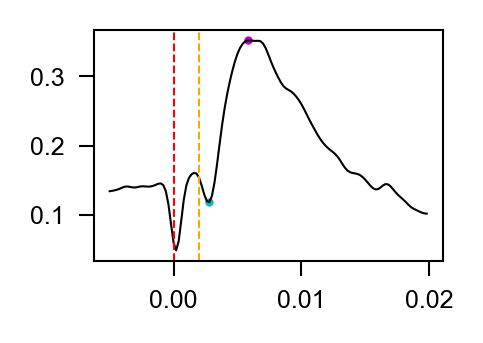

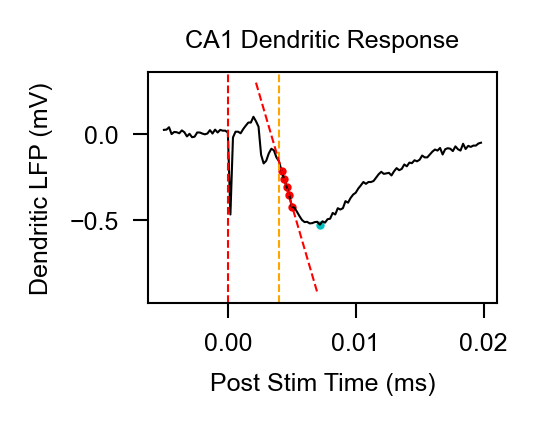

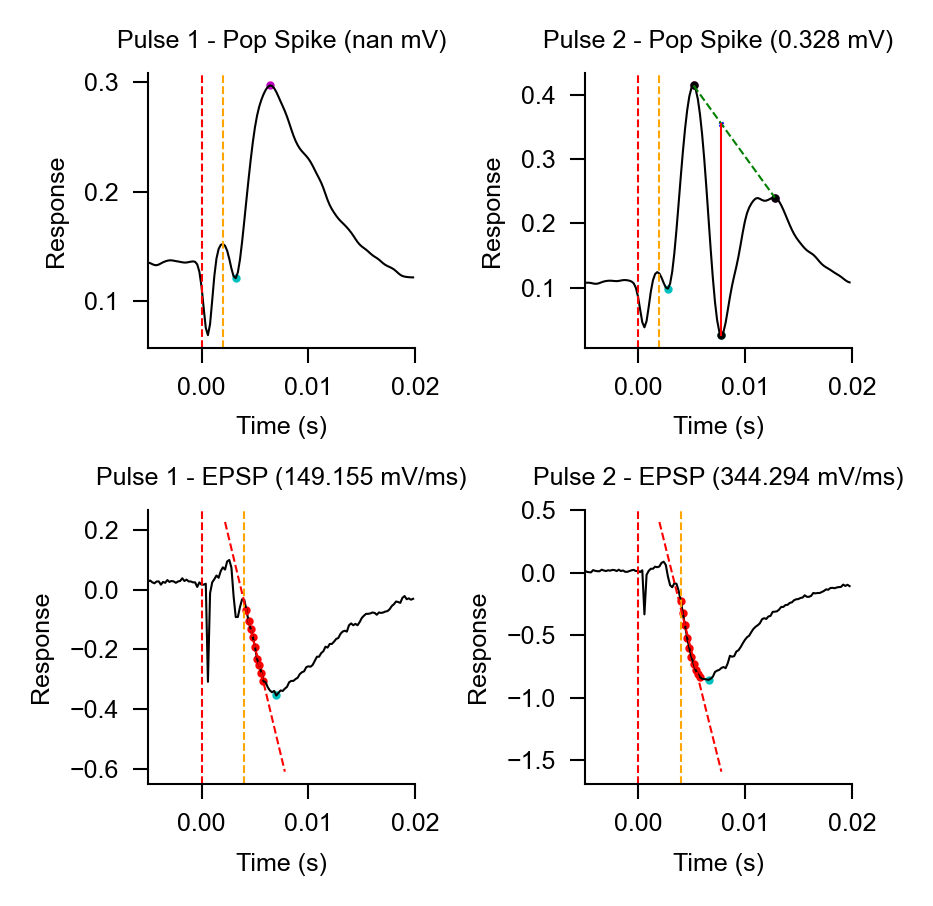

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S1_0002.abf
No flanking positive peaks found
No flanking positive peaks found


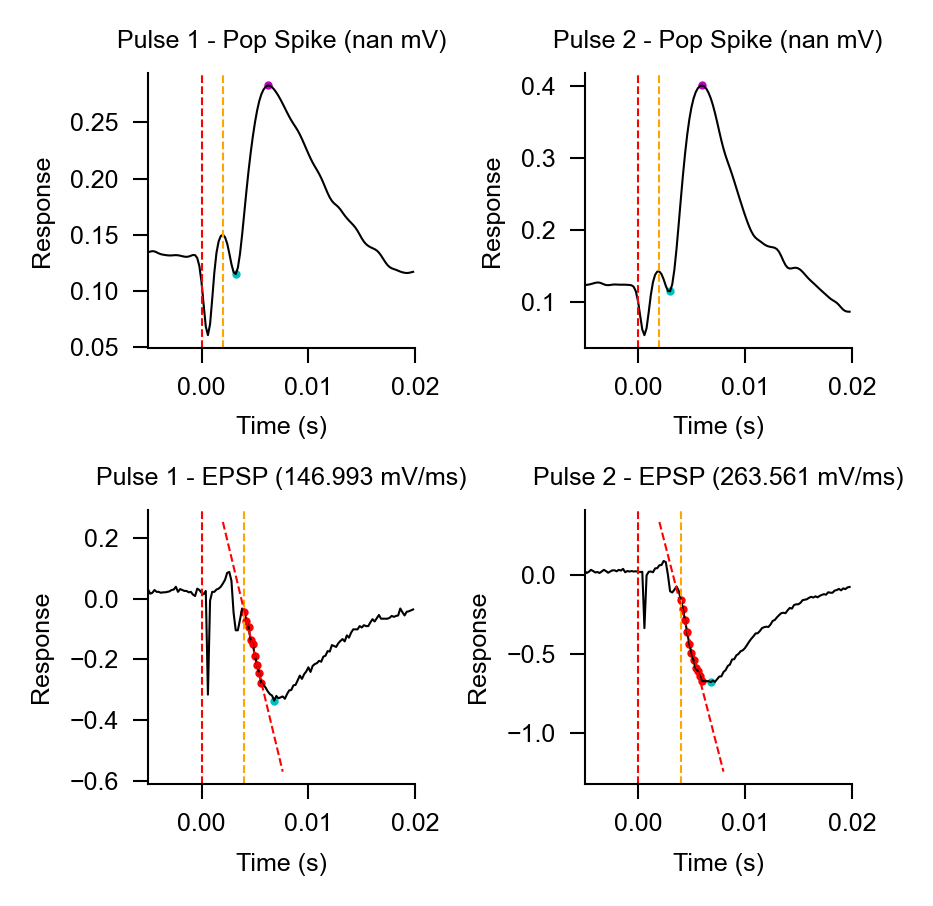

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S1_0003.abf
No flanking positive peaks found
No flanking positive peaks found


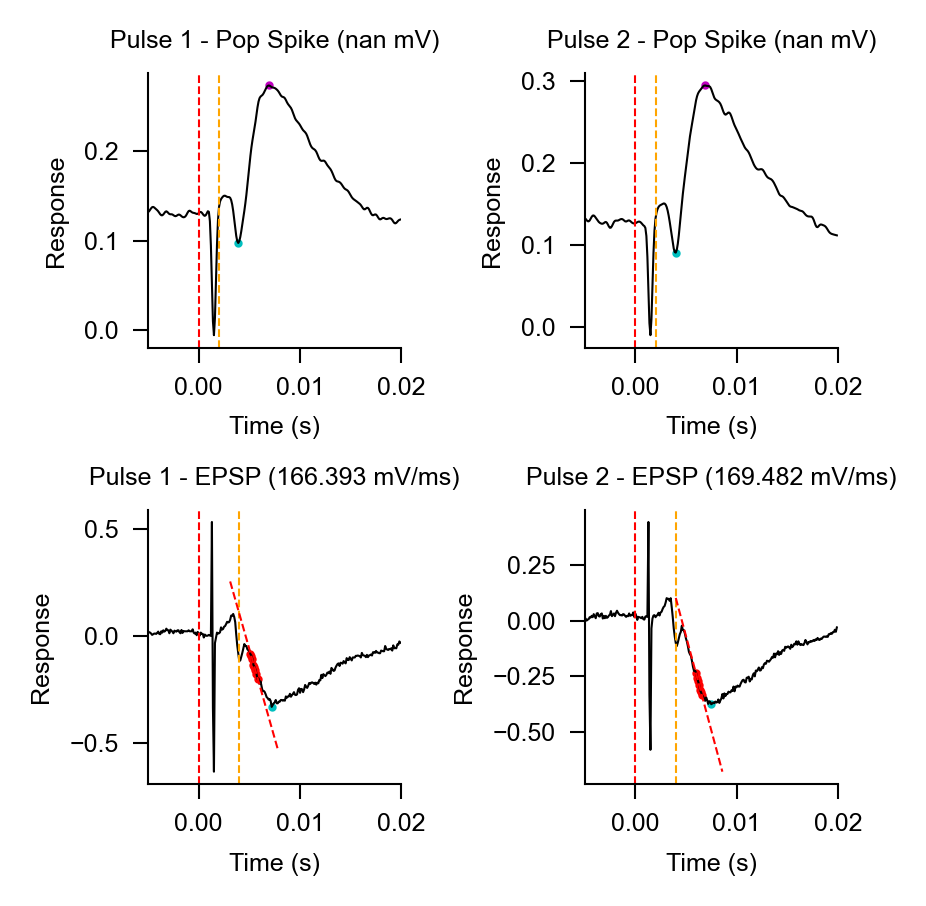

Skipping Wash-In Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S1_0004.abf: Invalid Condition Format
Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S1_0005.abf
No negative peaks detected
No flanking positive peaks found
No negative peaks detected
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S1_0006.abf
No flanking positive peaks found


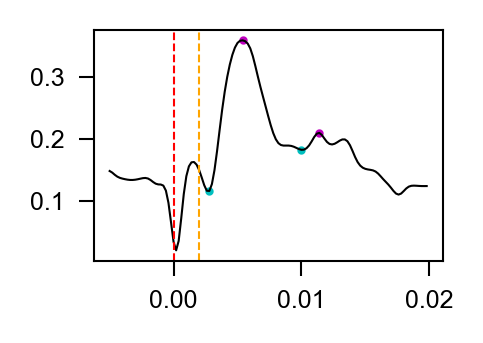

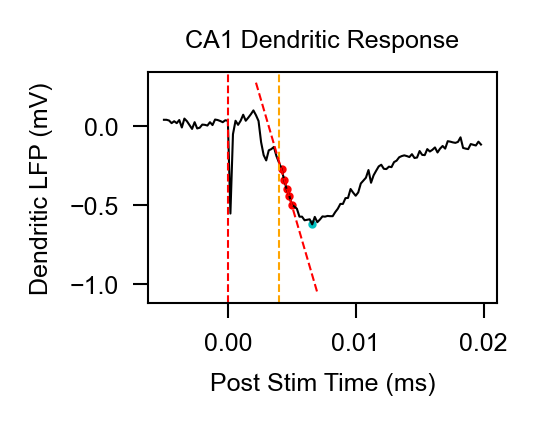

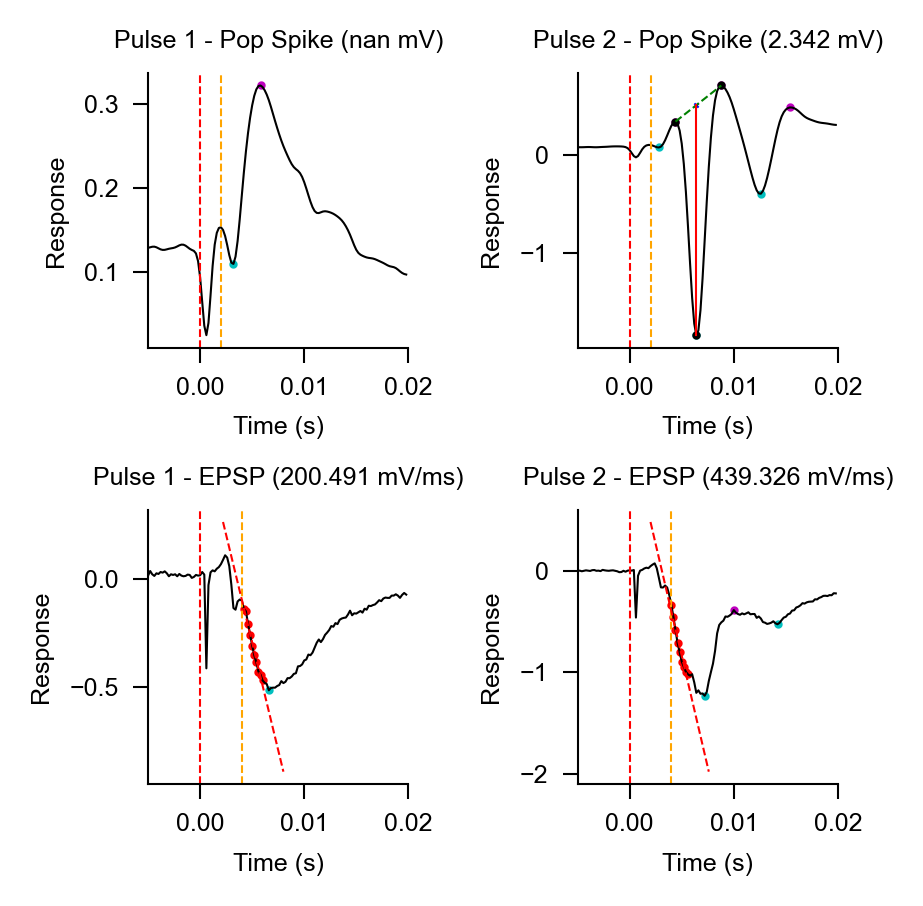

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S1_0007.abf
No flanking positive peaks found


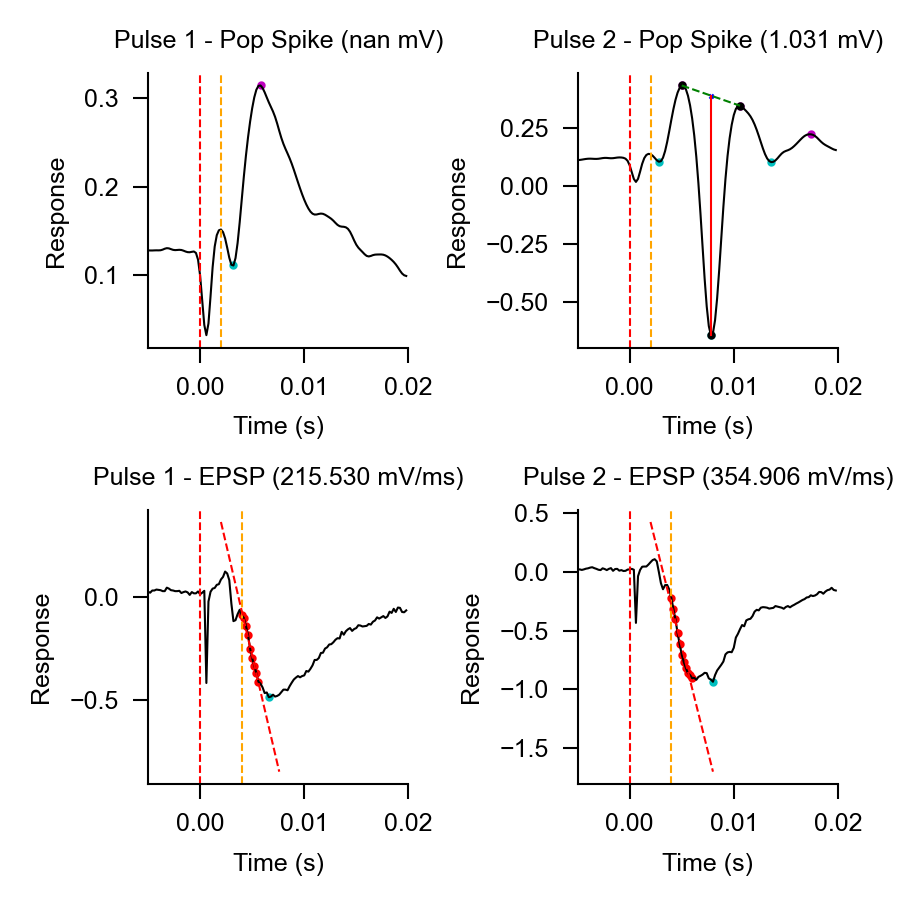

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S1_0008.abf


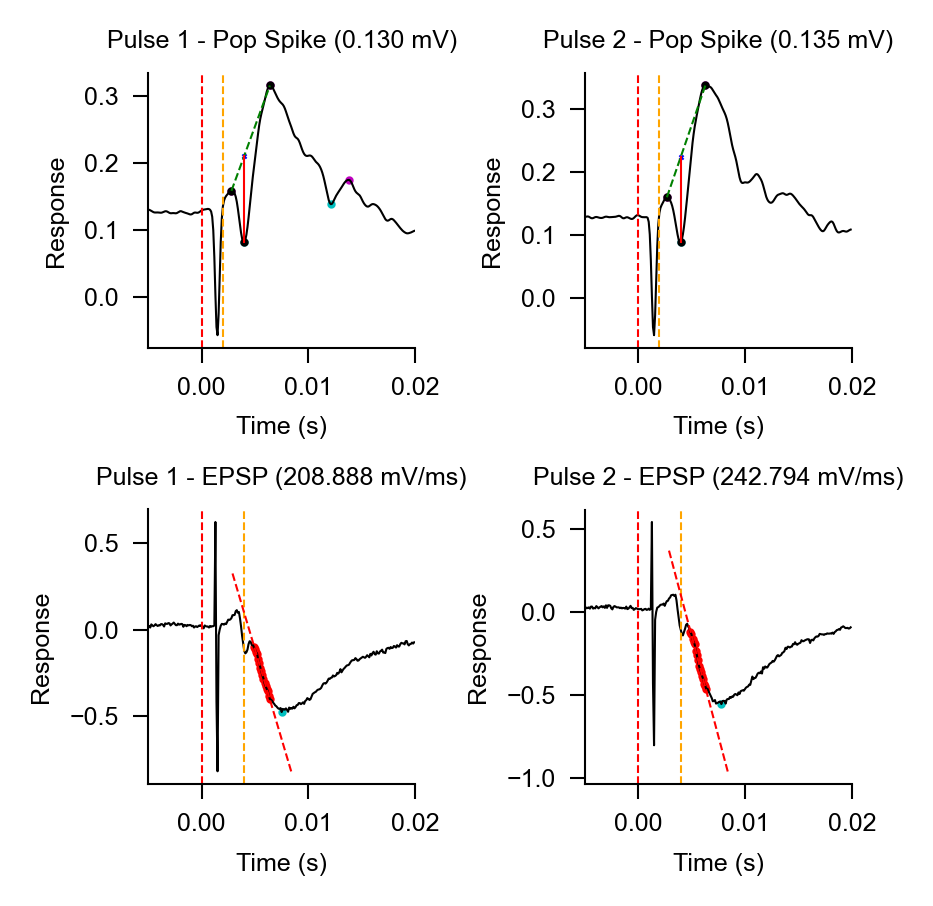

Skipping Wash-In Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S1_0009.abf: Invalid Condition Format
Skipping Wash-In Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S1_0010.abf: Invalid Condition Format
Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S2_0000.abf
No negative peaks detected
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S2_0001.abf
No flanking positive peaks found


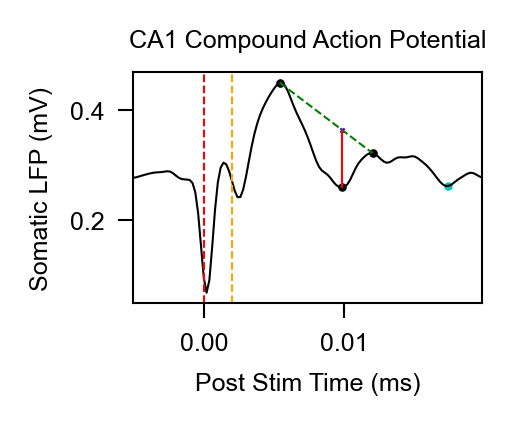

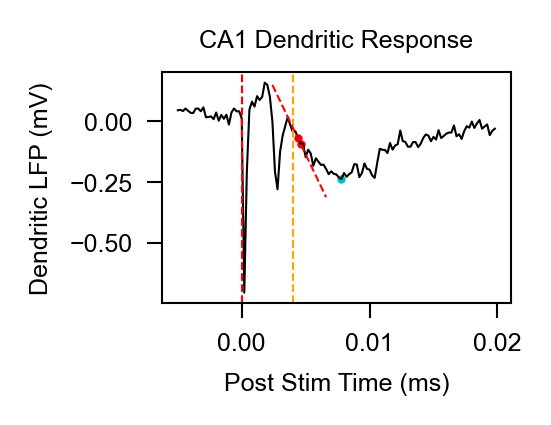

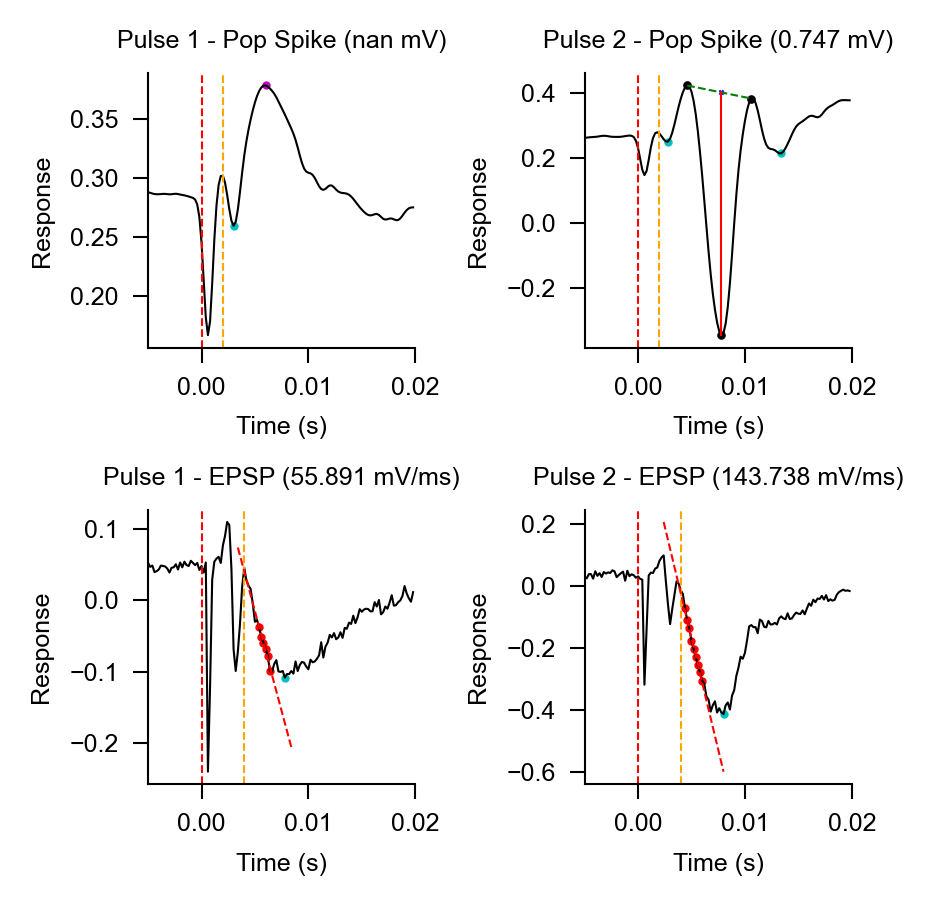

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S2_0002.abf
No flanking positive peaks found


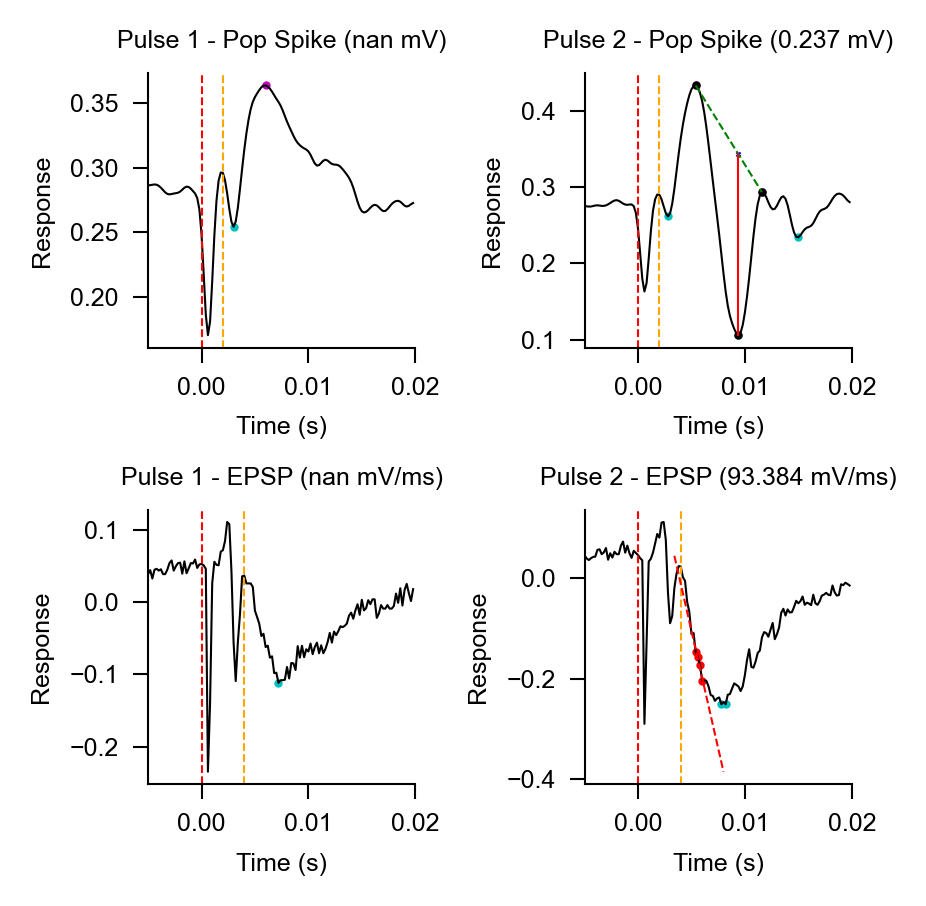

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S2_0003.abf


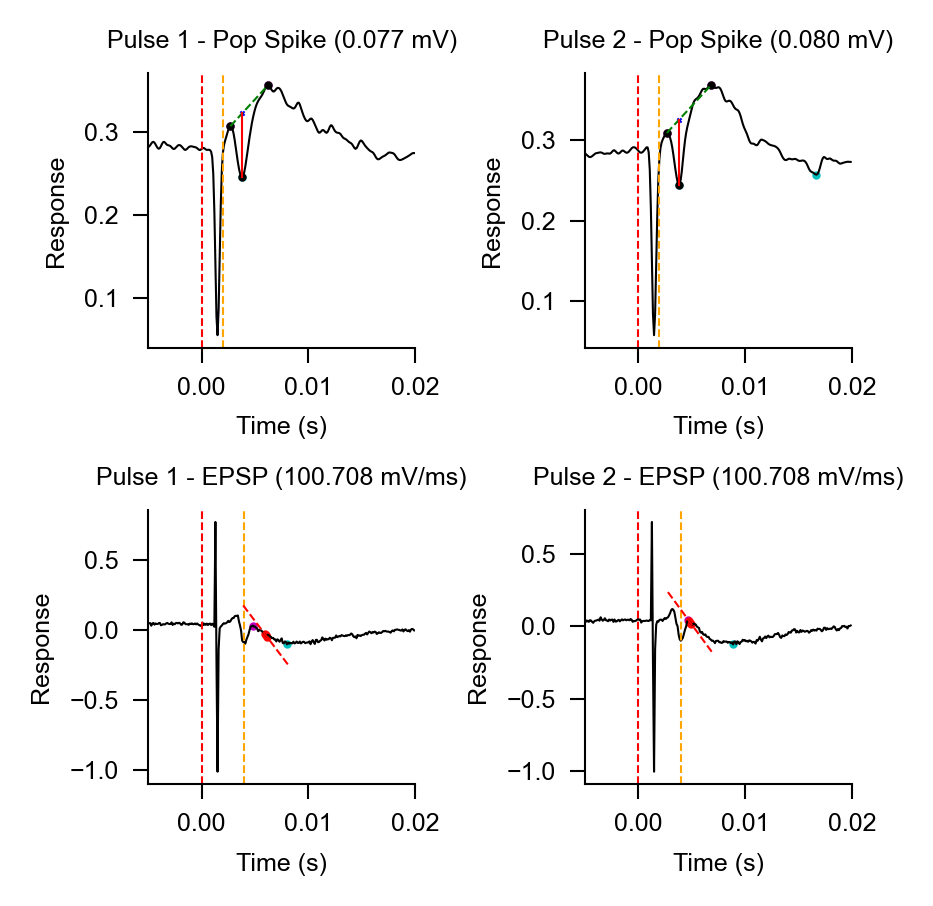

Skipping Wash-In Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S2_0004.abf: Invalid Condition Format
Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S2_0005.abf
No negative peaks detected
No negative peaks detected
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S2_0006.abf


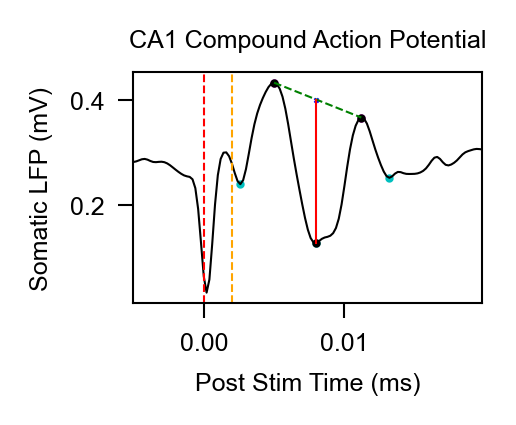

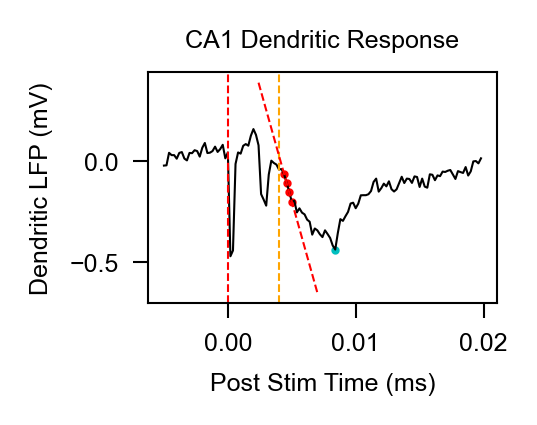

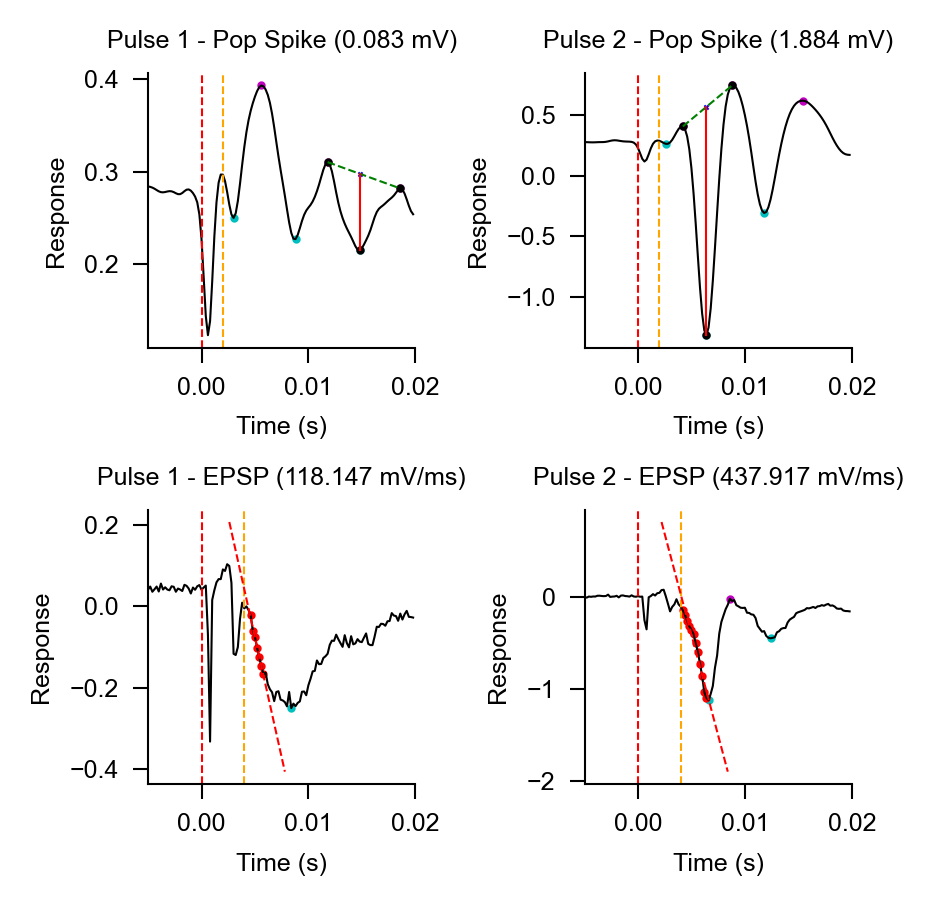

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S2_0007.abf
No flanking positive peaks found


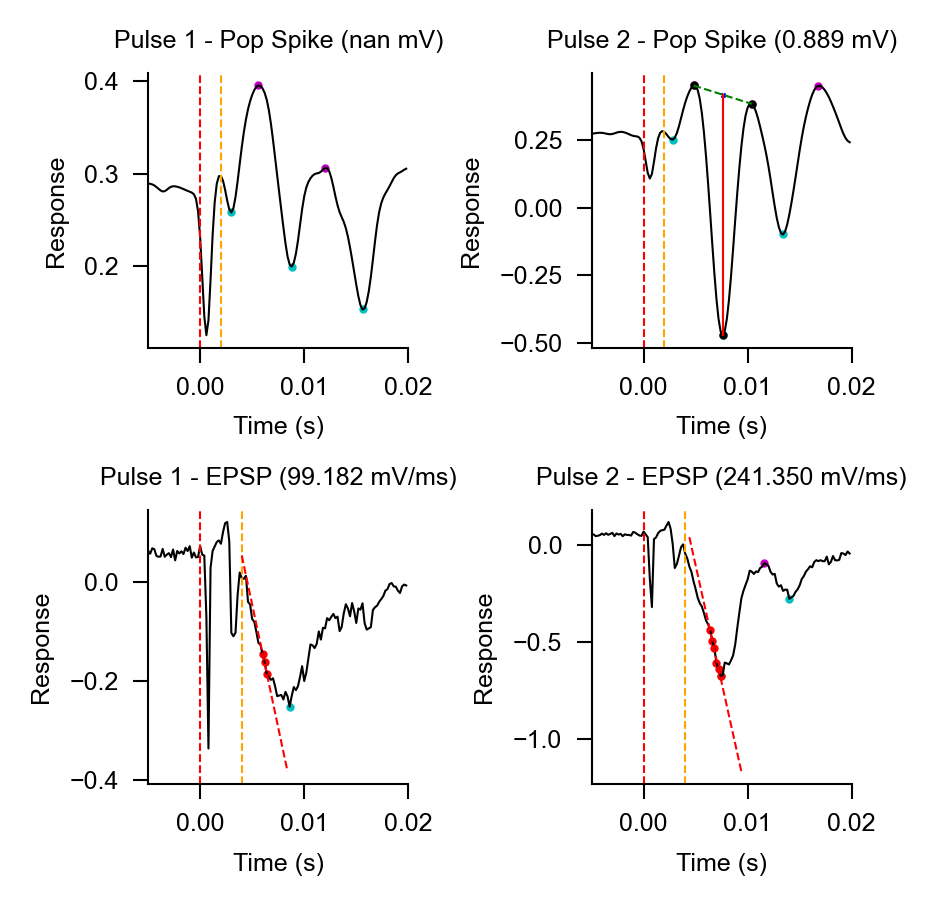

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x21_\2025x03x21_E3KI_F_P160_sagi_S2_0008.abf
No flanking positive peaks found


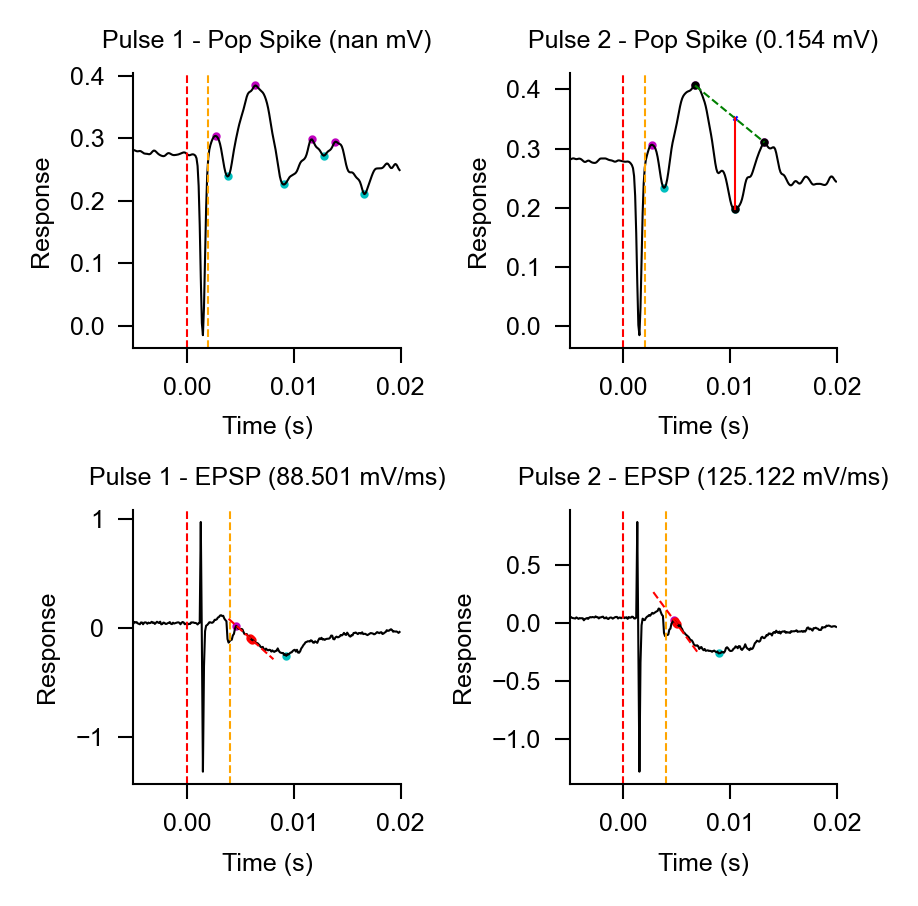

Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s001_0000.abf
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s001_0001.abf


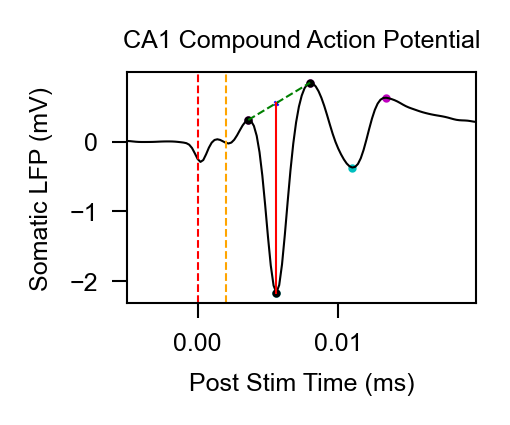

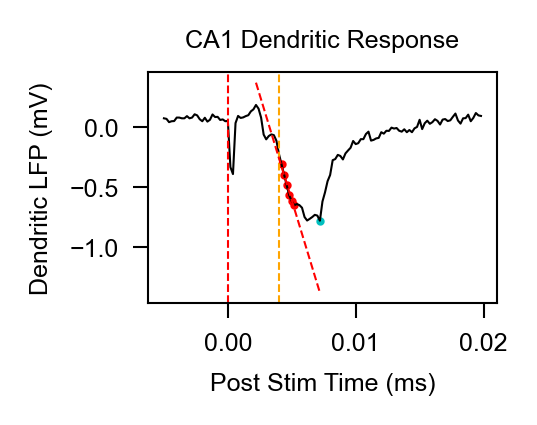

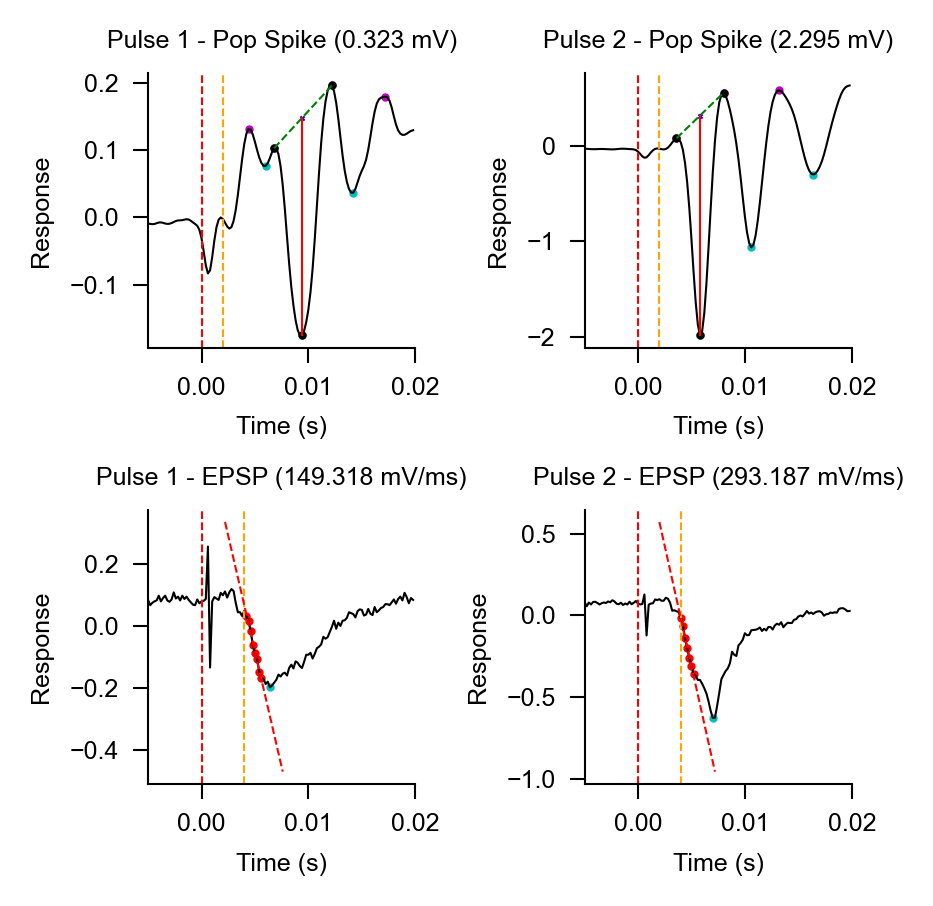

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s001_0002.abf


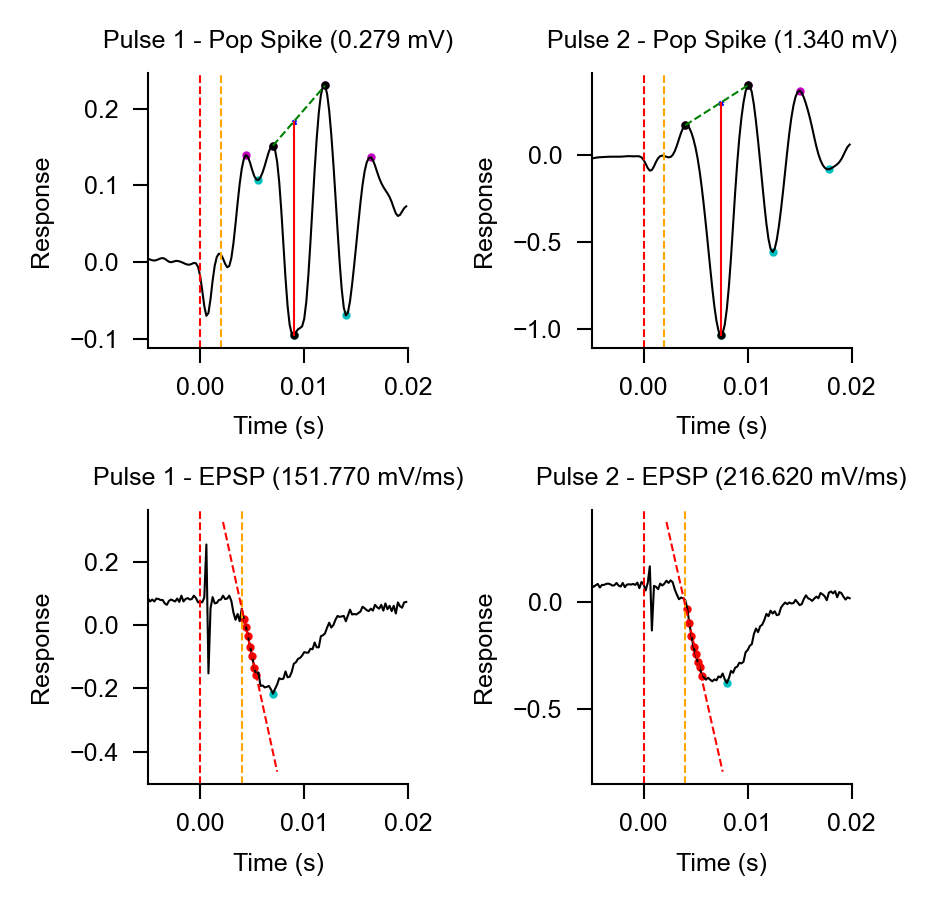

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s001_0003.abf


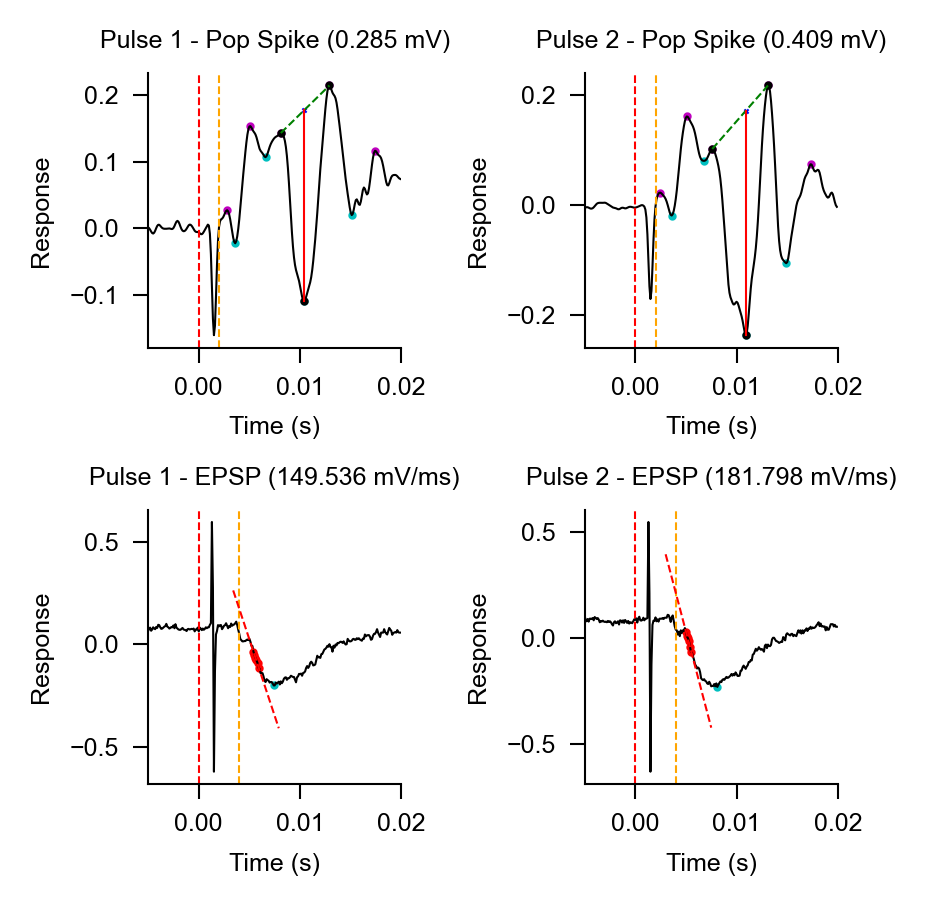

Applying Wash-In Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s001_0004.abf, Switch Time: 10.25 min


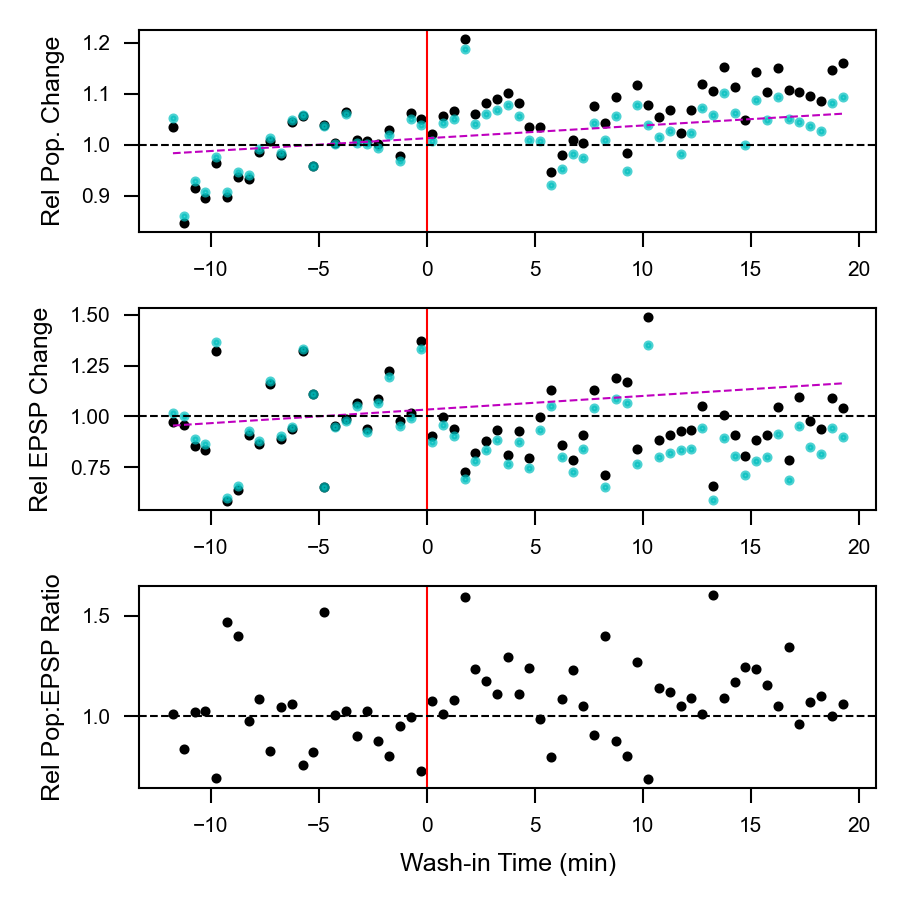

Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s001_0005.abf
No flanking positive peaks found
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s001_0006.abf


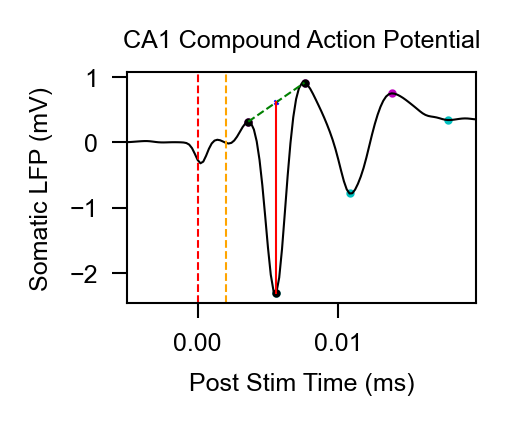

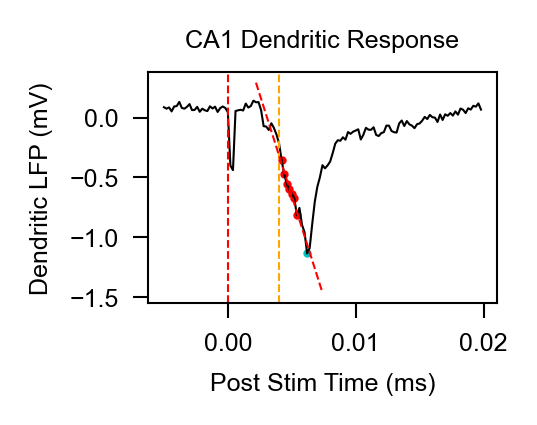

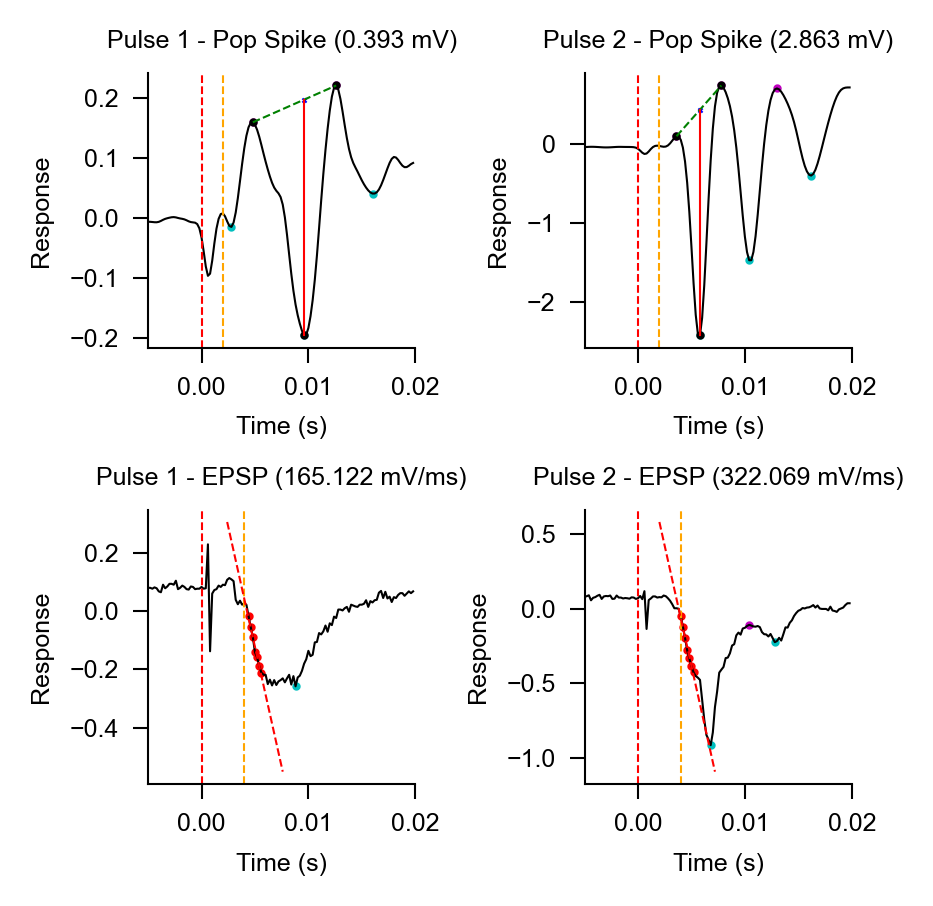

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s001_0007.abf


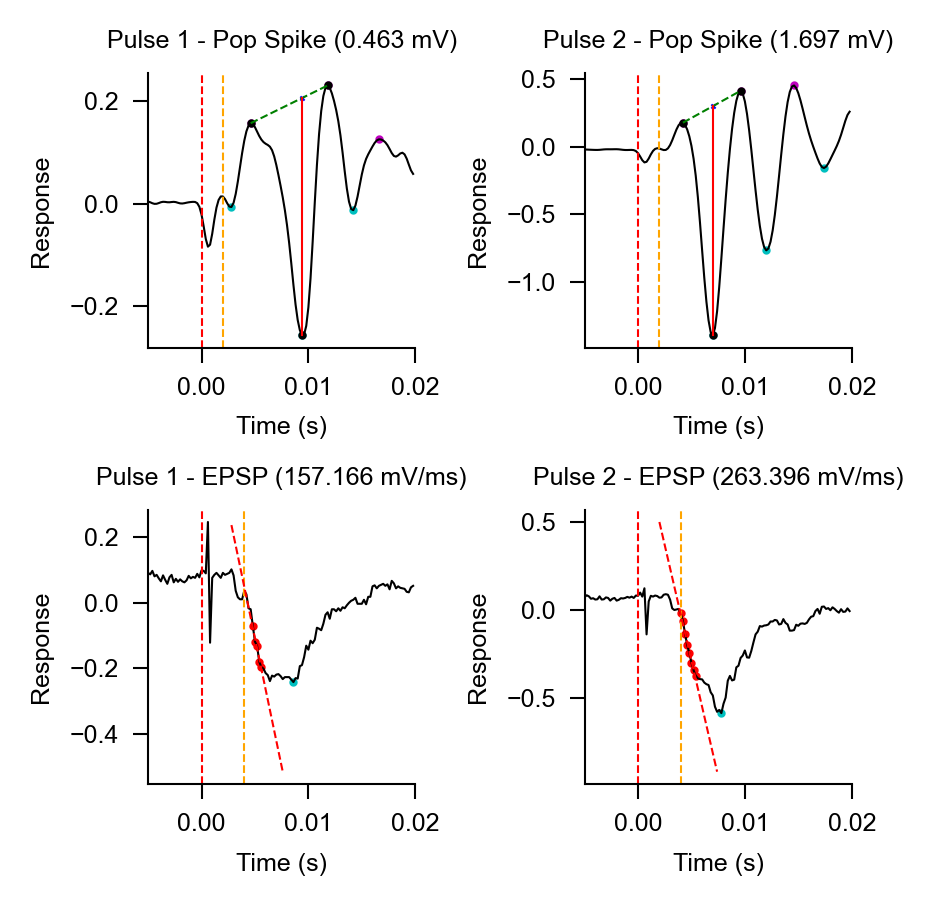

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s001_0008.abf


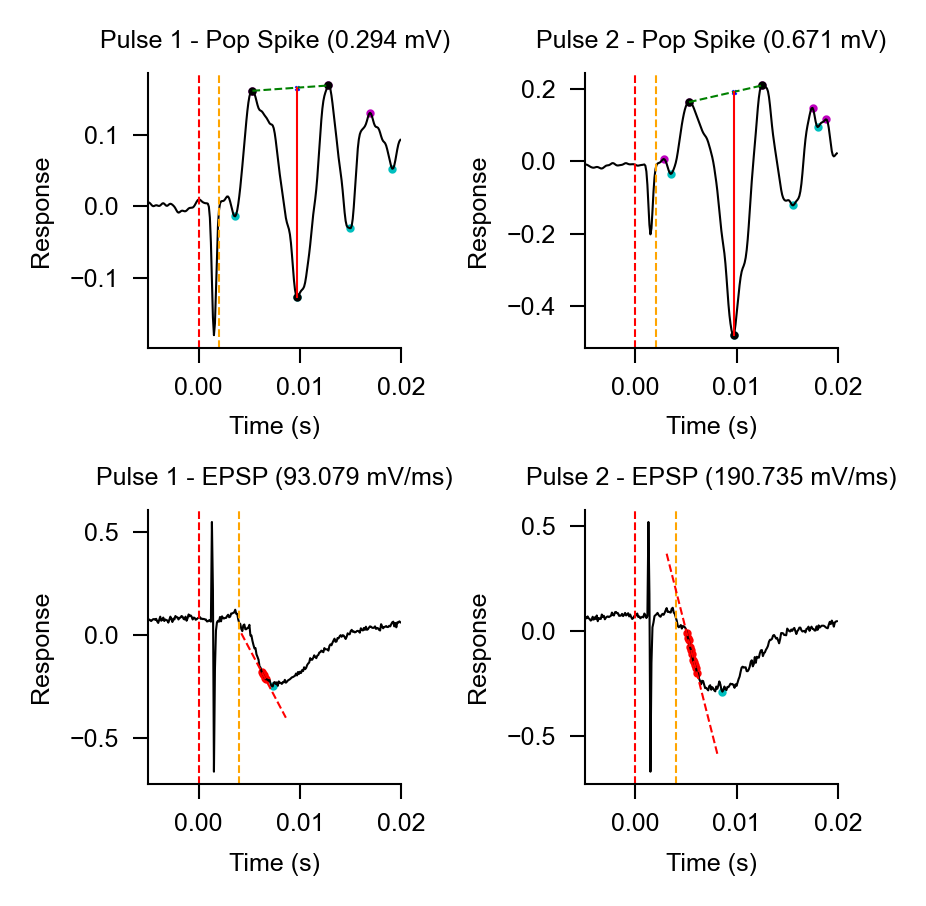

Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s002_0000.abf
No negative peaks detected
No negative peaks detected
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s002_0001.abf
No negative peaks detected


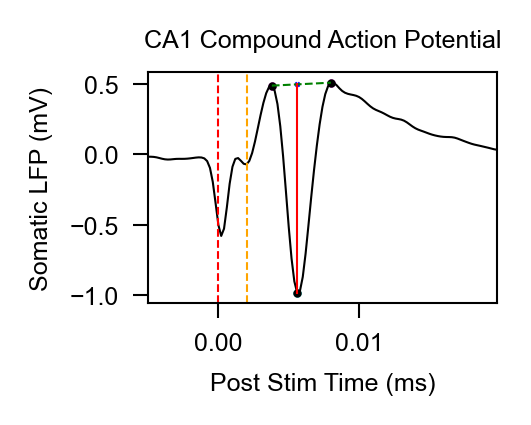

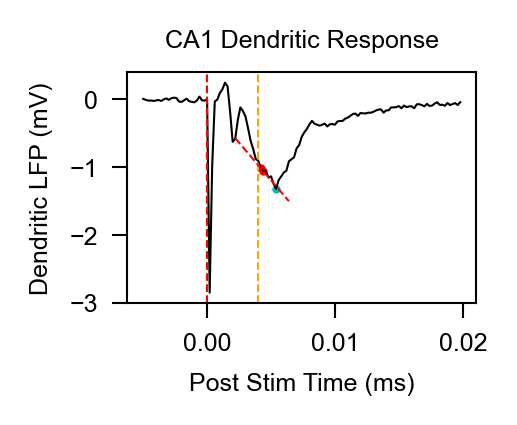

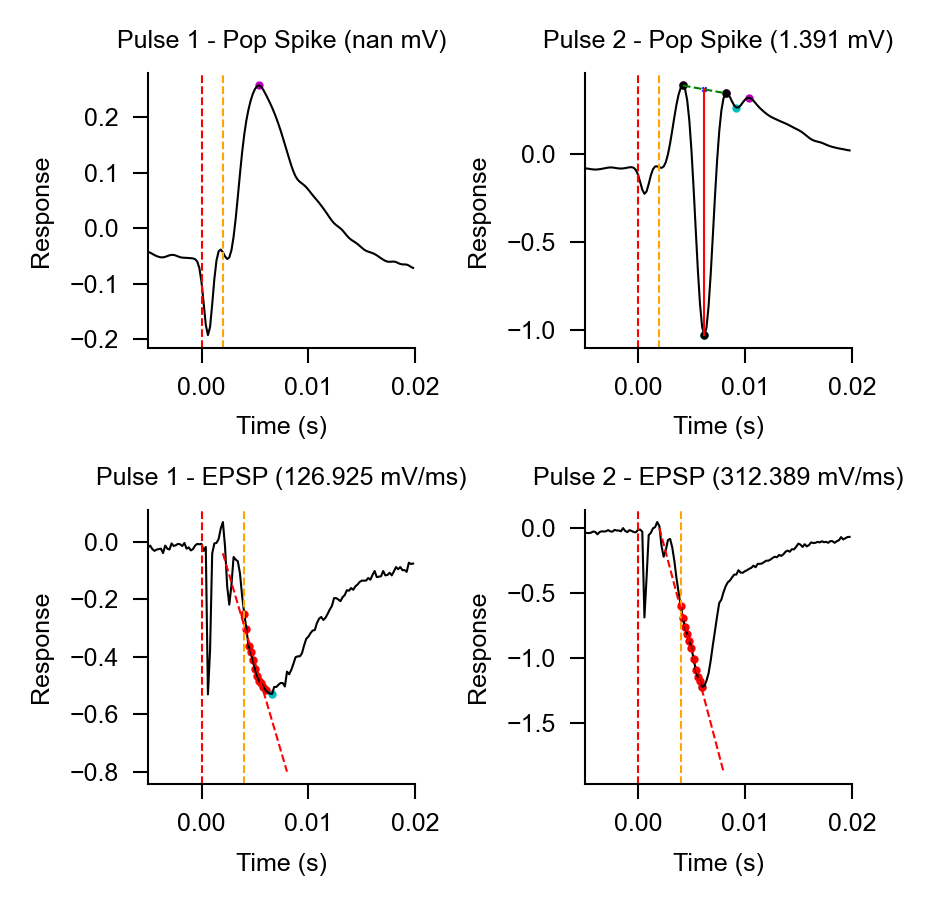

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s002_0002.abf
No negative peaks detected


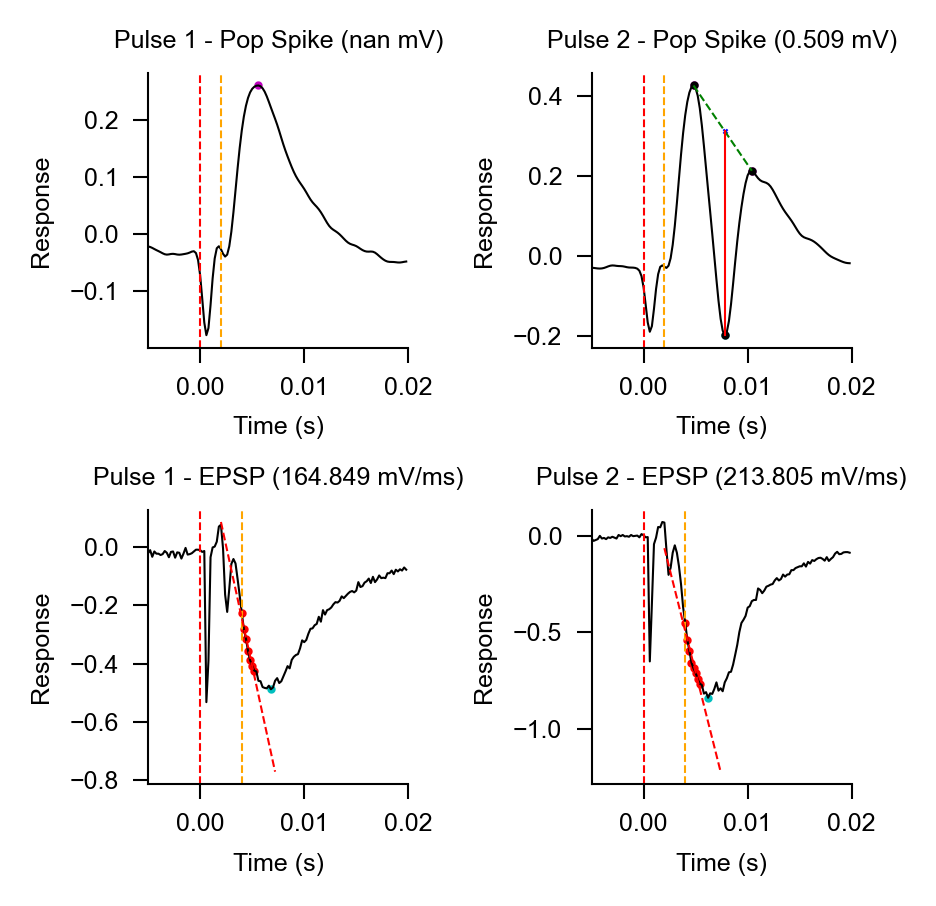

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s002_0003.abf


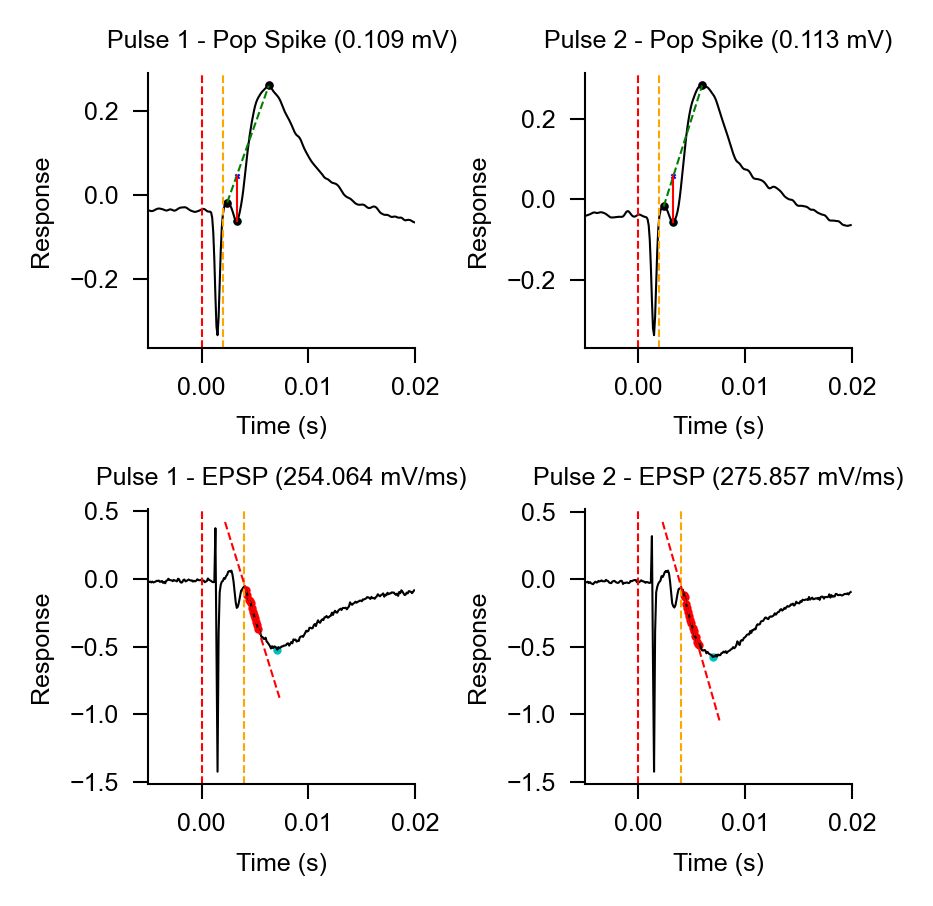

Applying Wash-In Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s002_0004.abf, Switch Time: 14.75 min


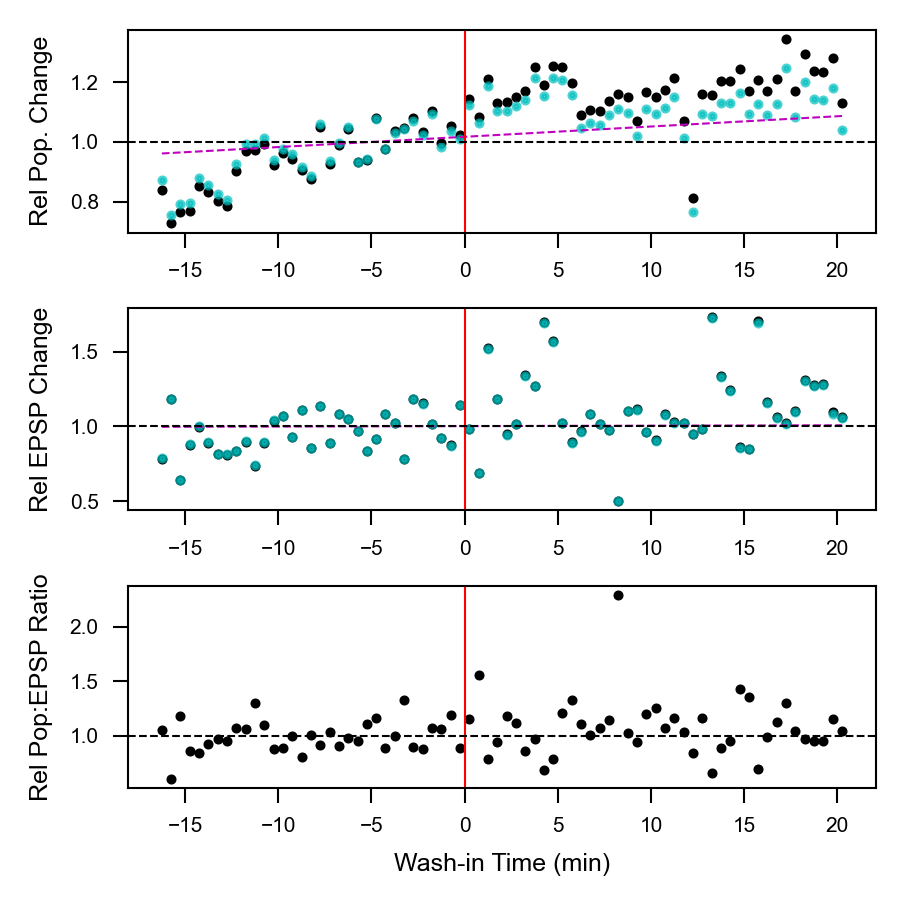

Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s002_0005.abf
No flanking positive peaks found
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s002_0006.abf
No negative peaks detected


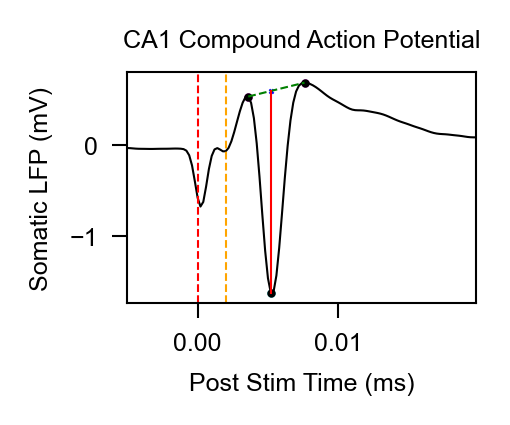

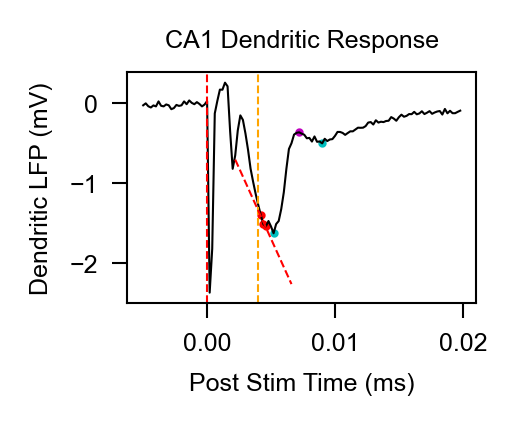

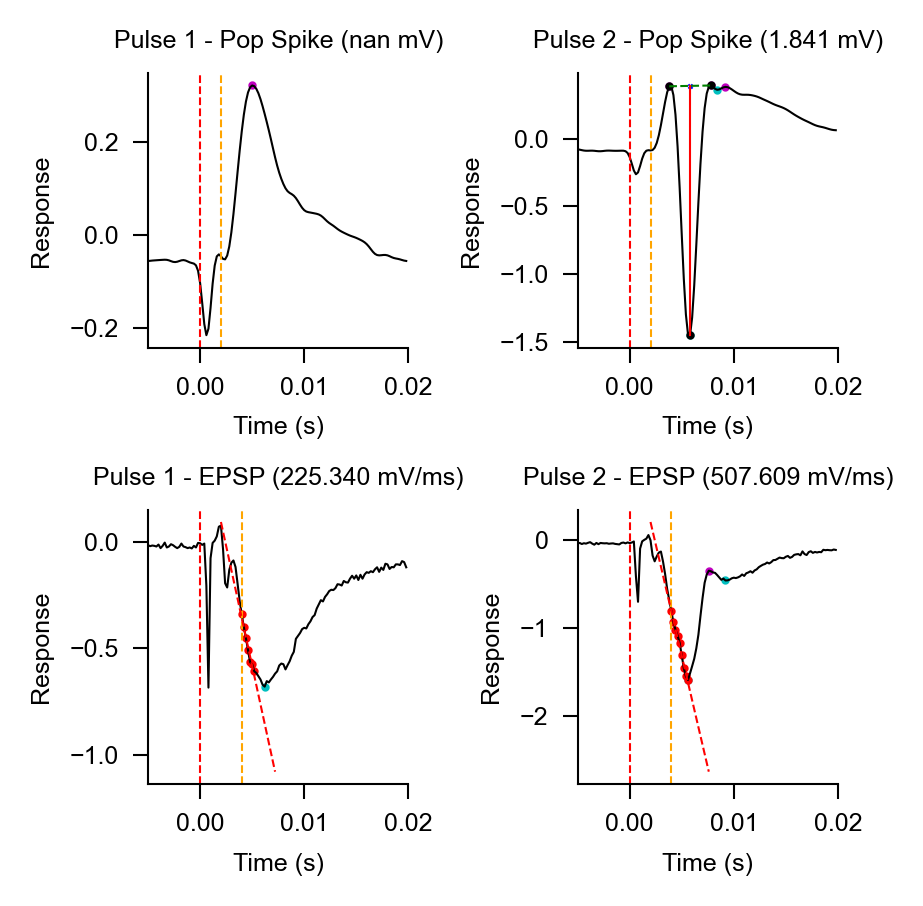

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s002_0007.abf


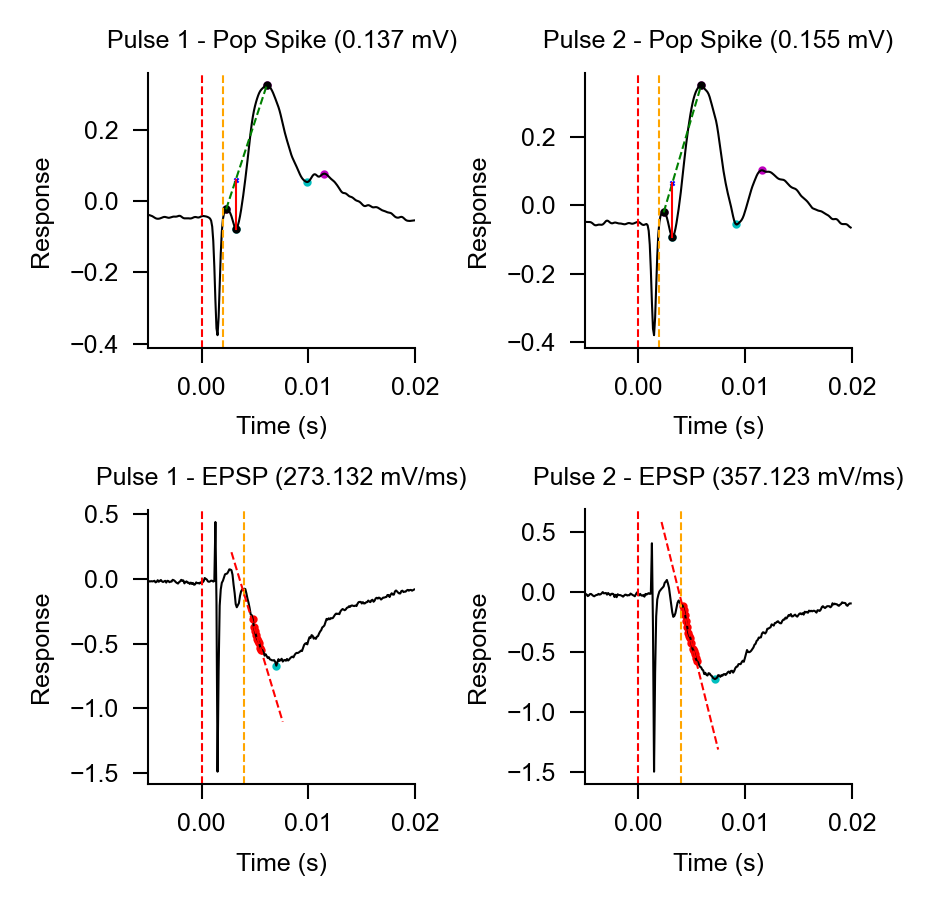

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s002_0008.abf
No negative peaks detected


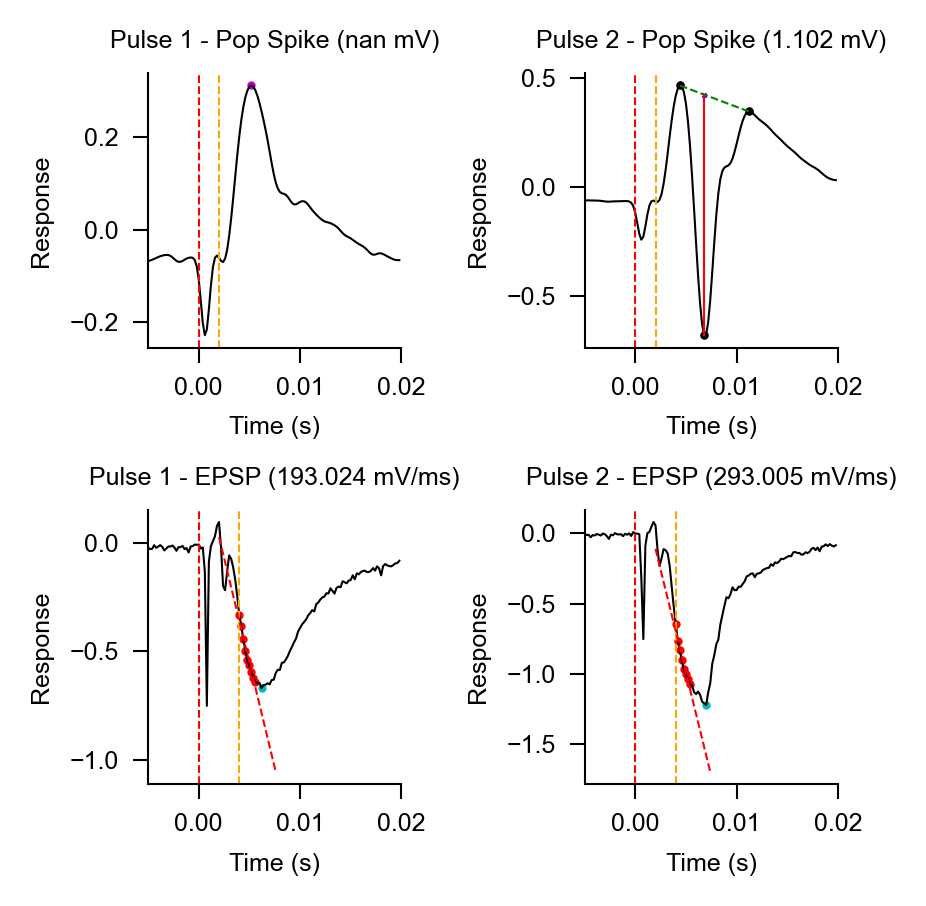

Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s003_0000.abf
No negative peaks detected
No negative peaks detected
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s003_0001.abf
No negative peaks detected


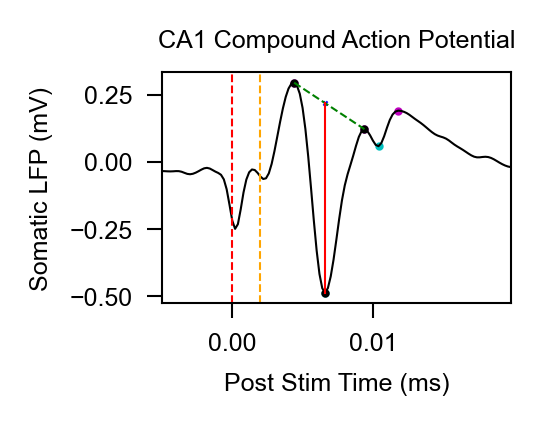

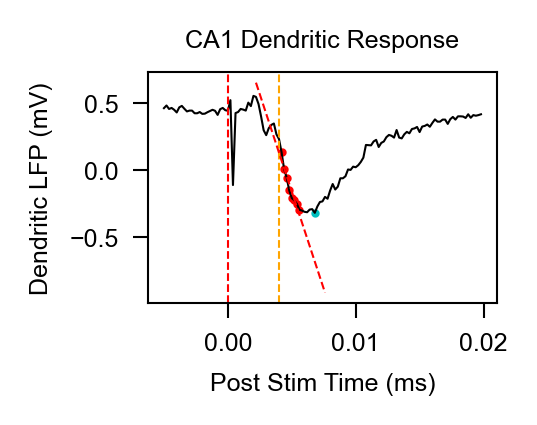

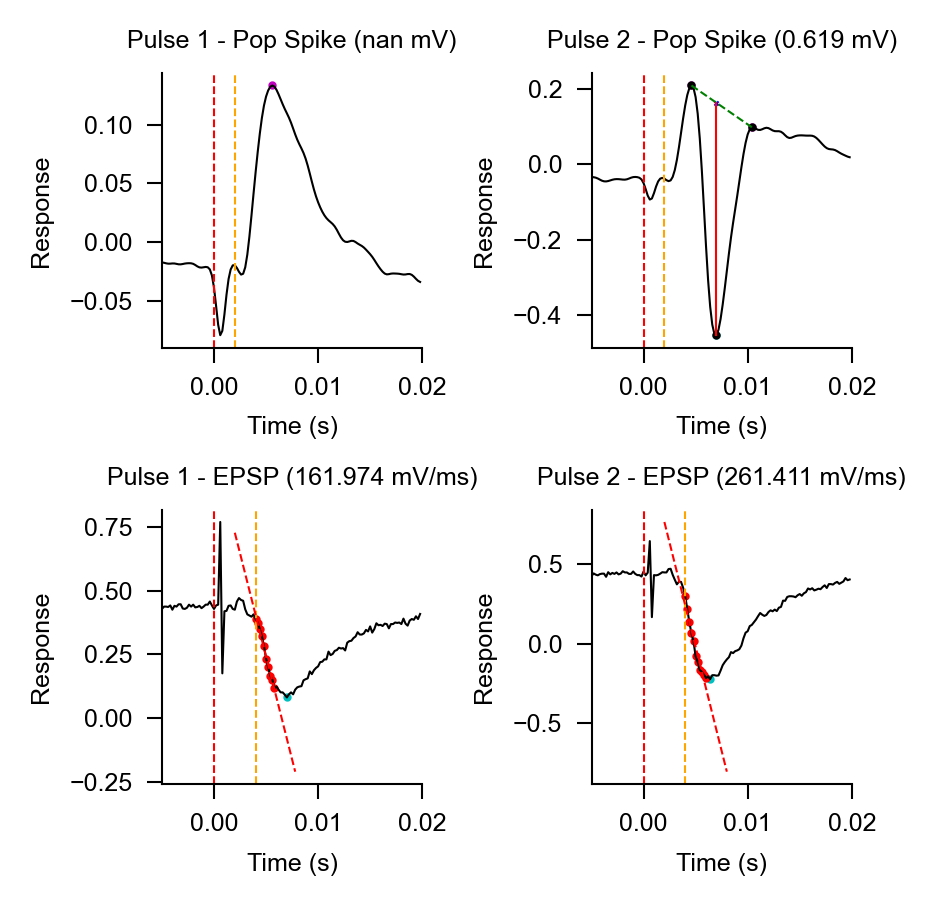

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s003_0002.abf
No flanking positive peaks found


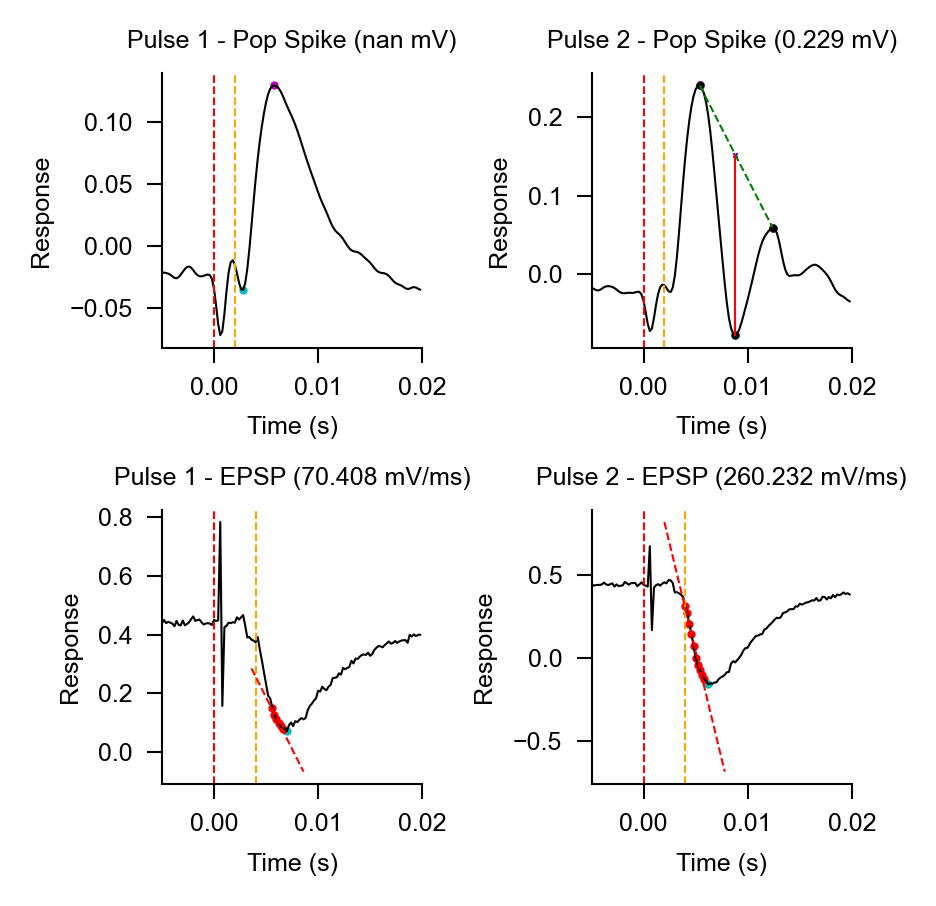

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s003_0003.abf
No flanking positive peaks found
No flanking positive peaks found


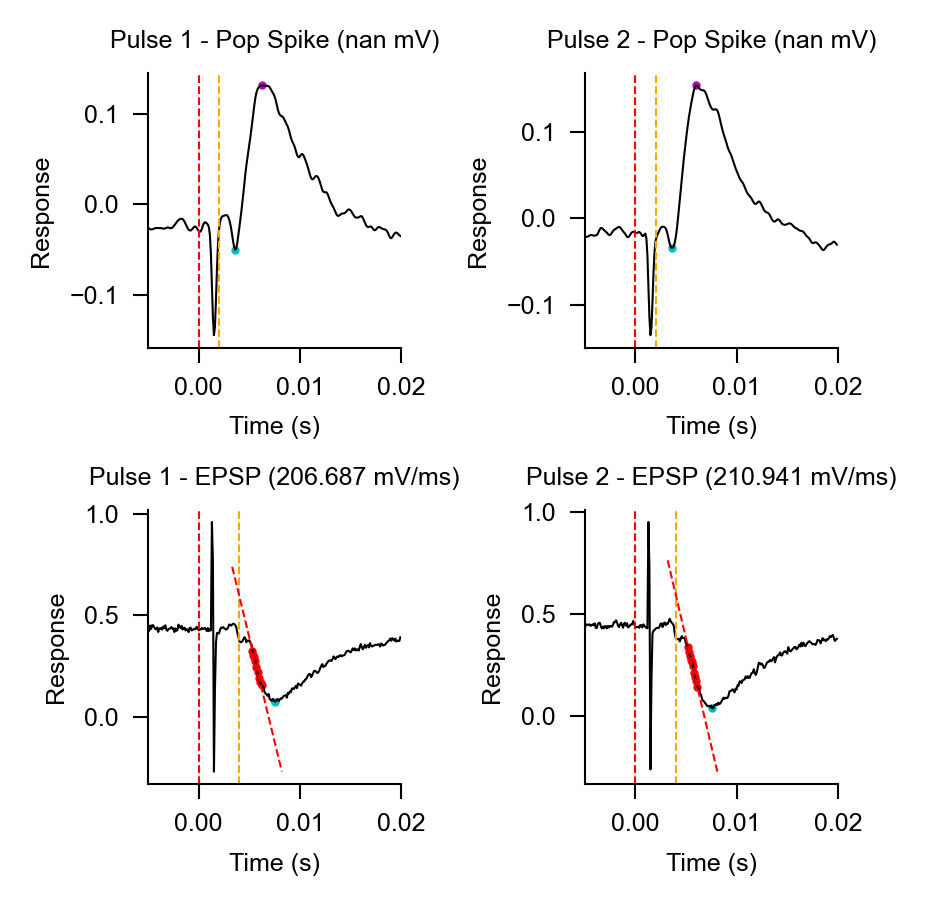

Applying Wash-In Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s003_0004.abf, Switch Time: 16.25 min


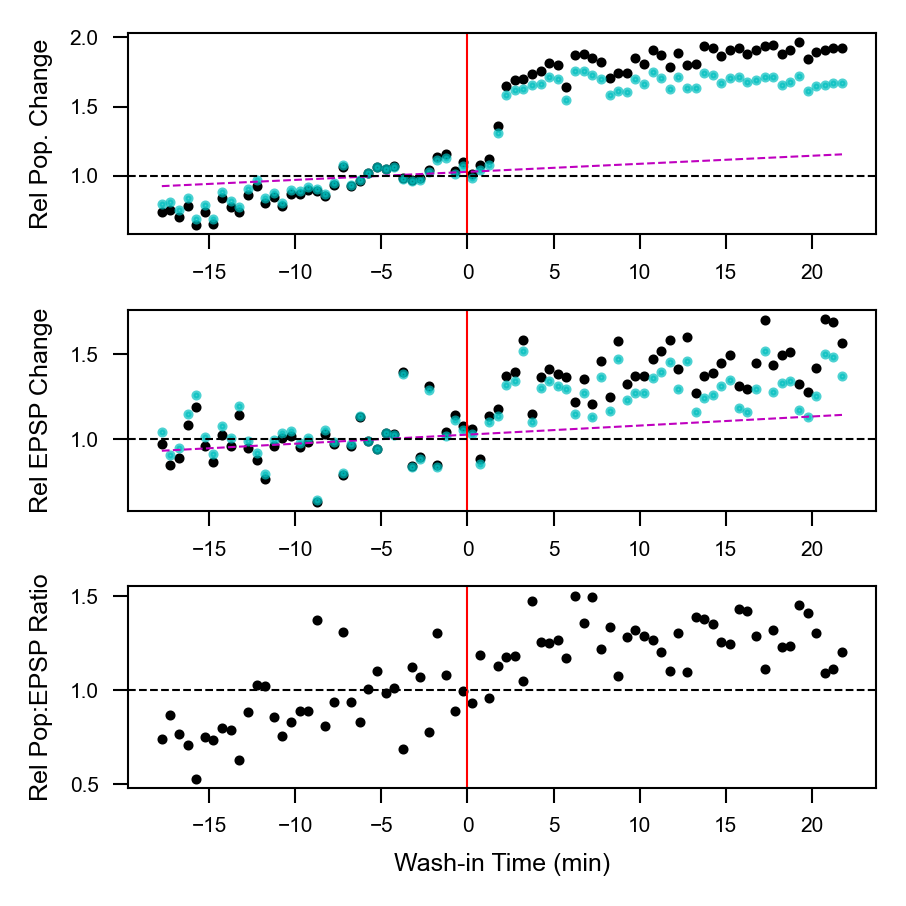

Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s003_0005.abf
No negative peaks detected
Early termination: No sufficiently long contiguous regions found.
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s003_0006.abf


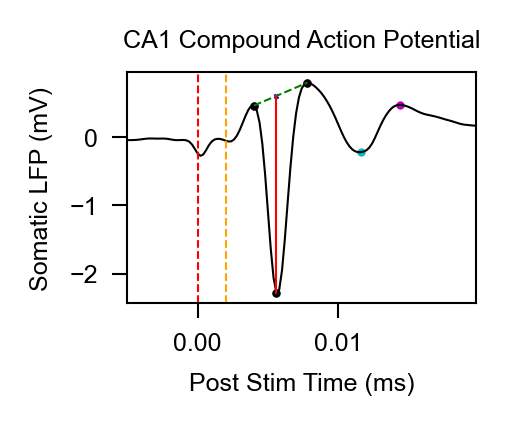

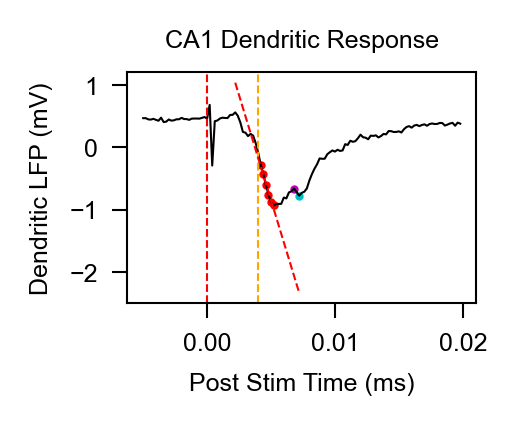

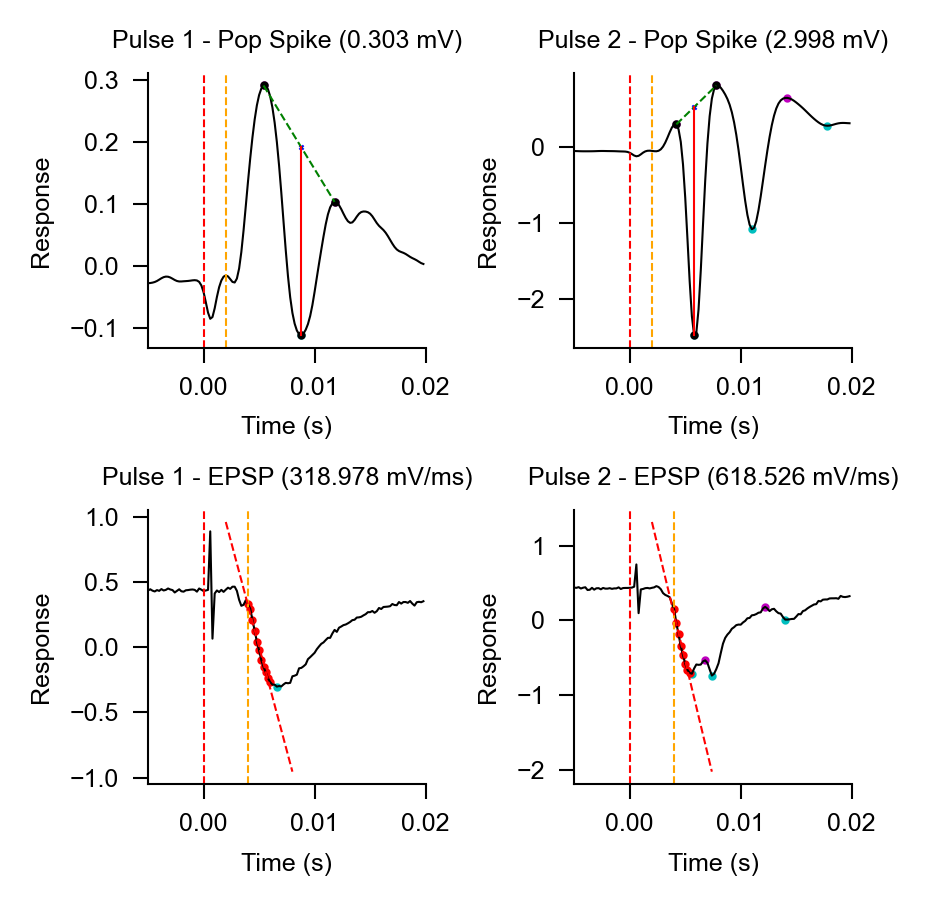

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s003_0007.abf


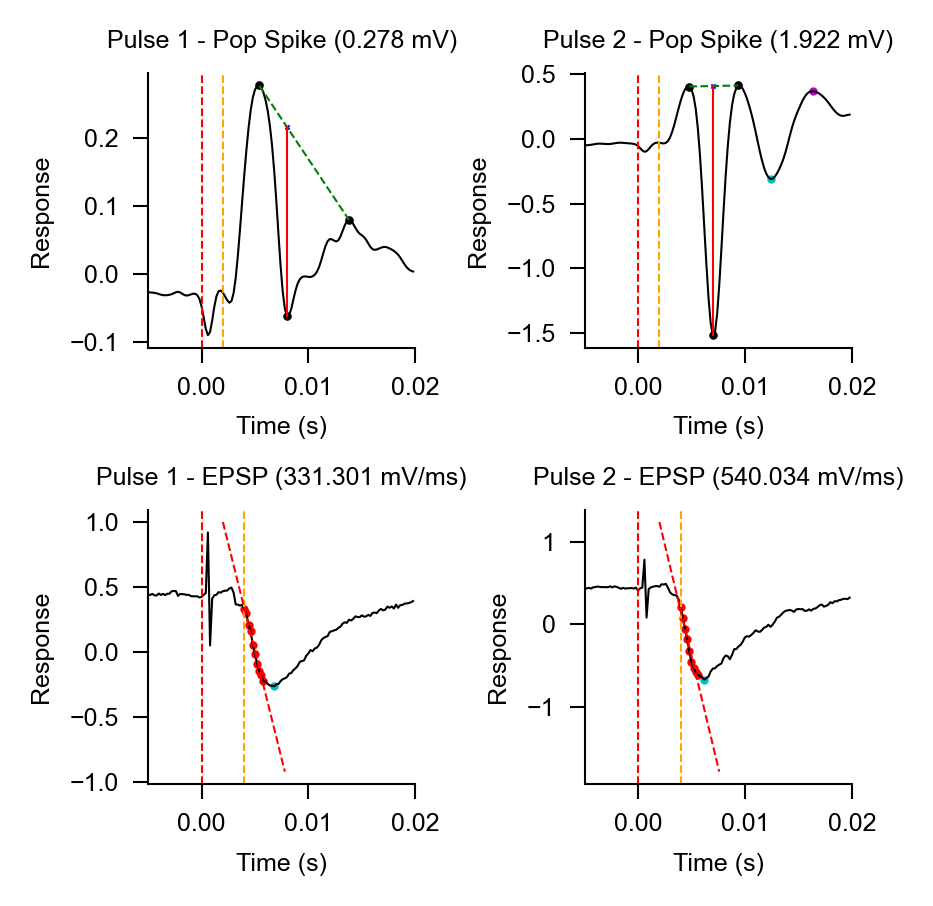

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s003_0008.abf


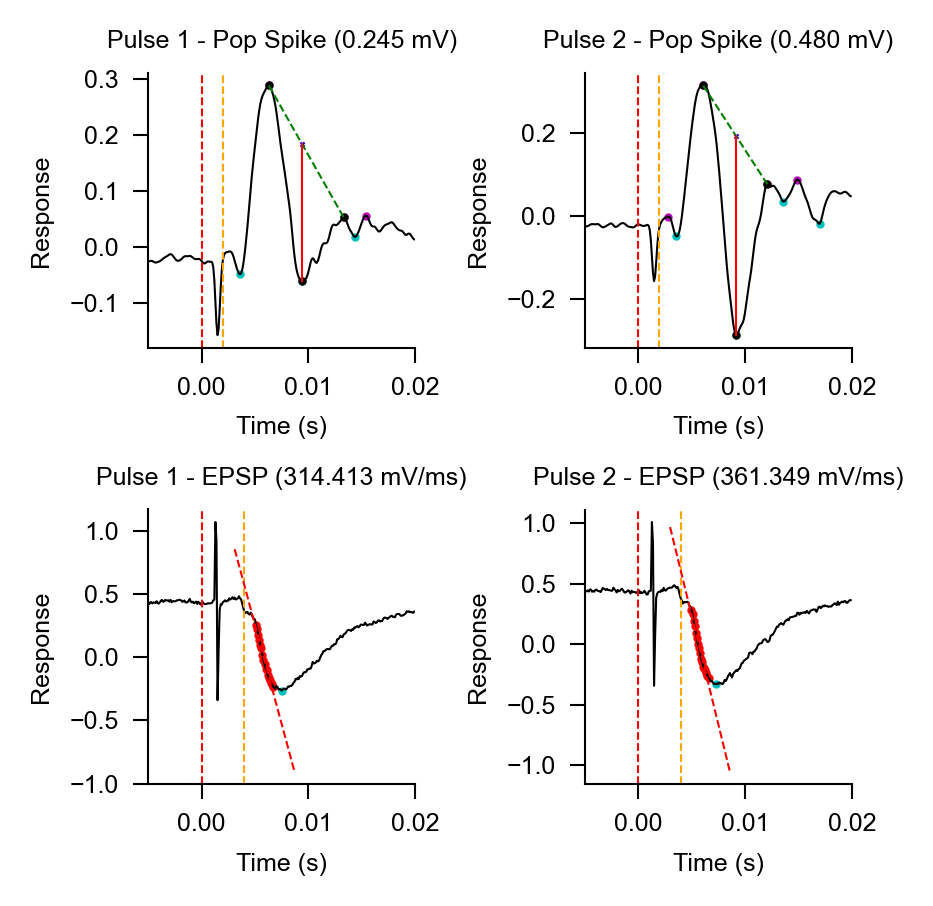

Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s004_0000.abf
No flanking positive peaks found
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s004_0001.abf
No negative peaks detected


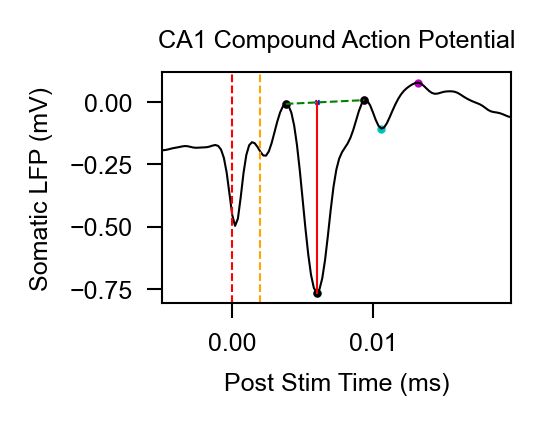

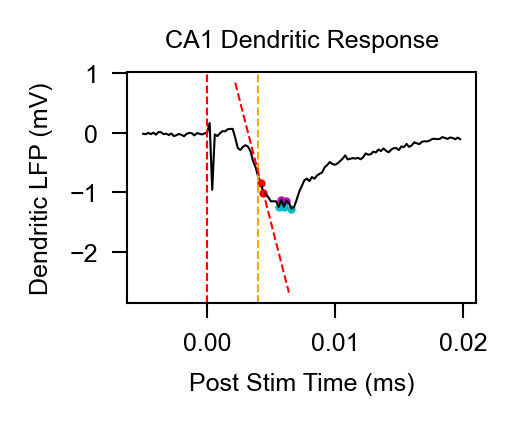

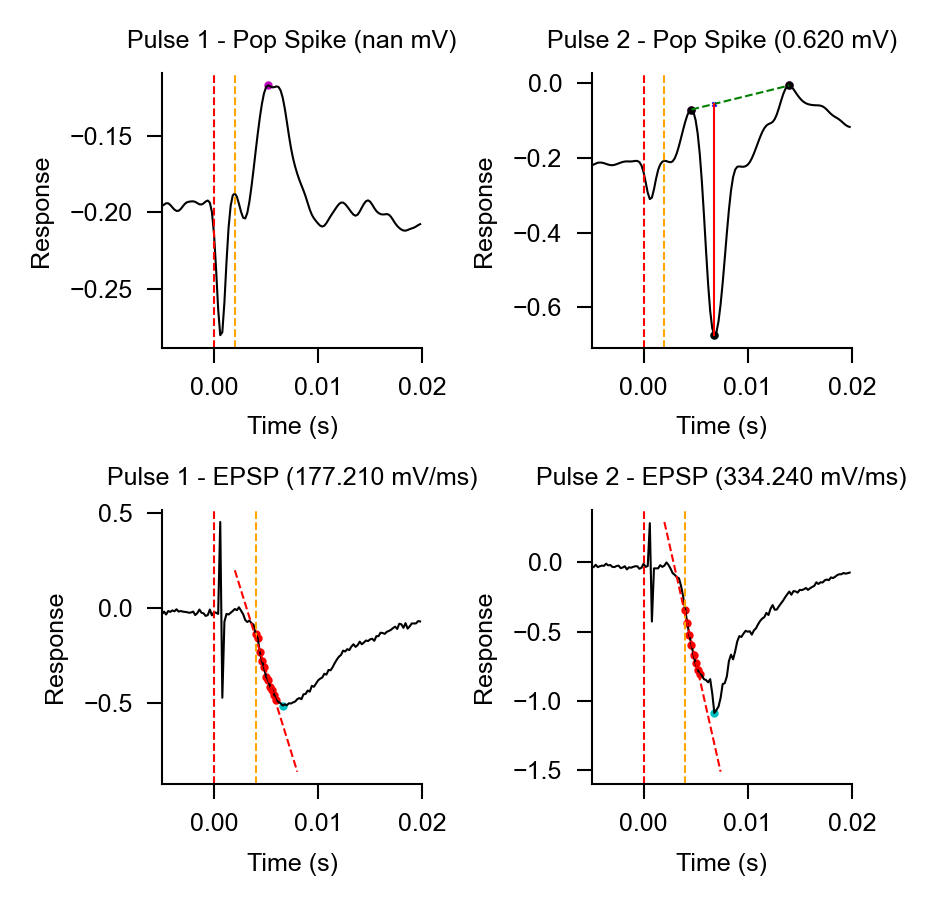

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s004_0002.abf
No negative peaks detected


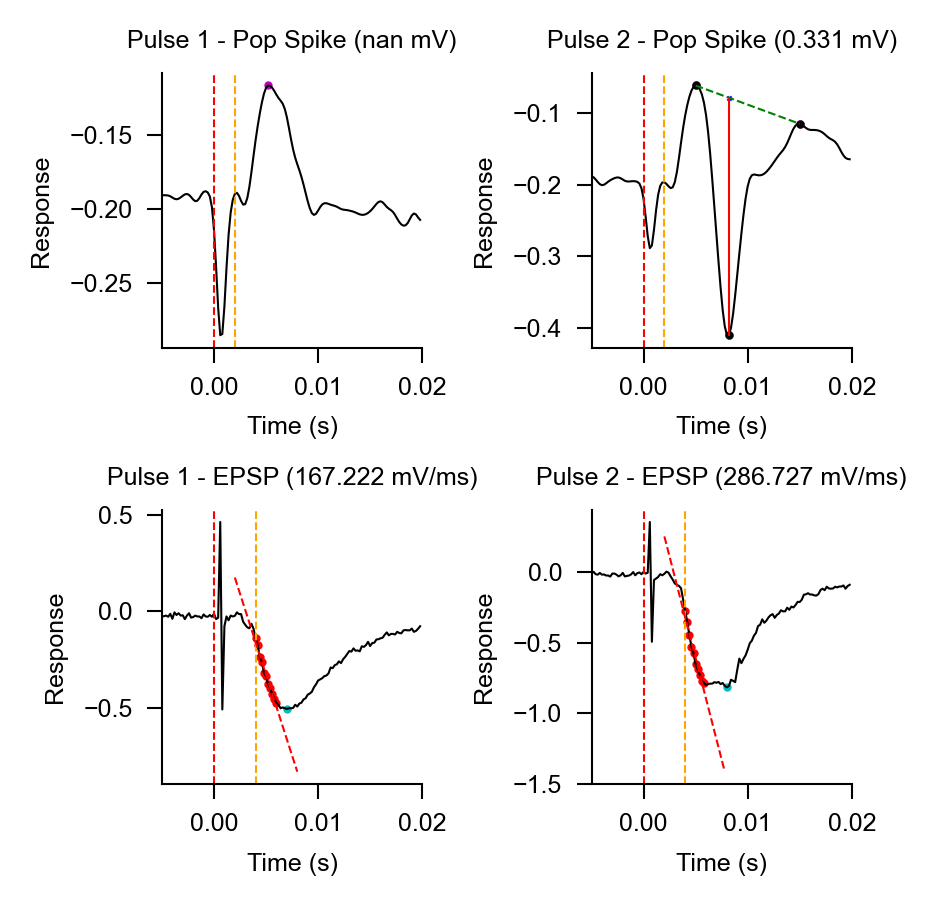

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s004_0003.abf


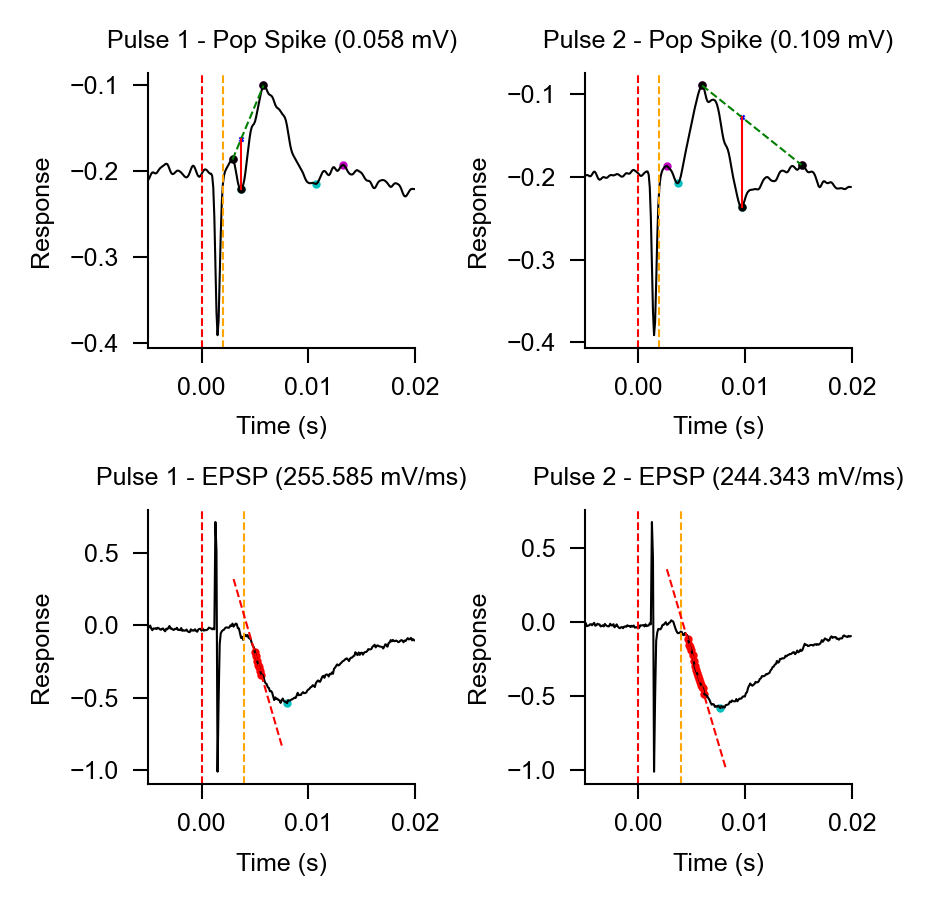

Applying Wash-In Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s004_0004.abf, Switch Time: 17.0 min


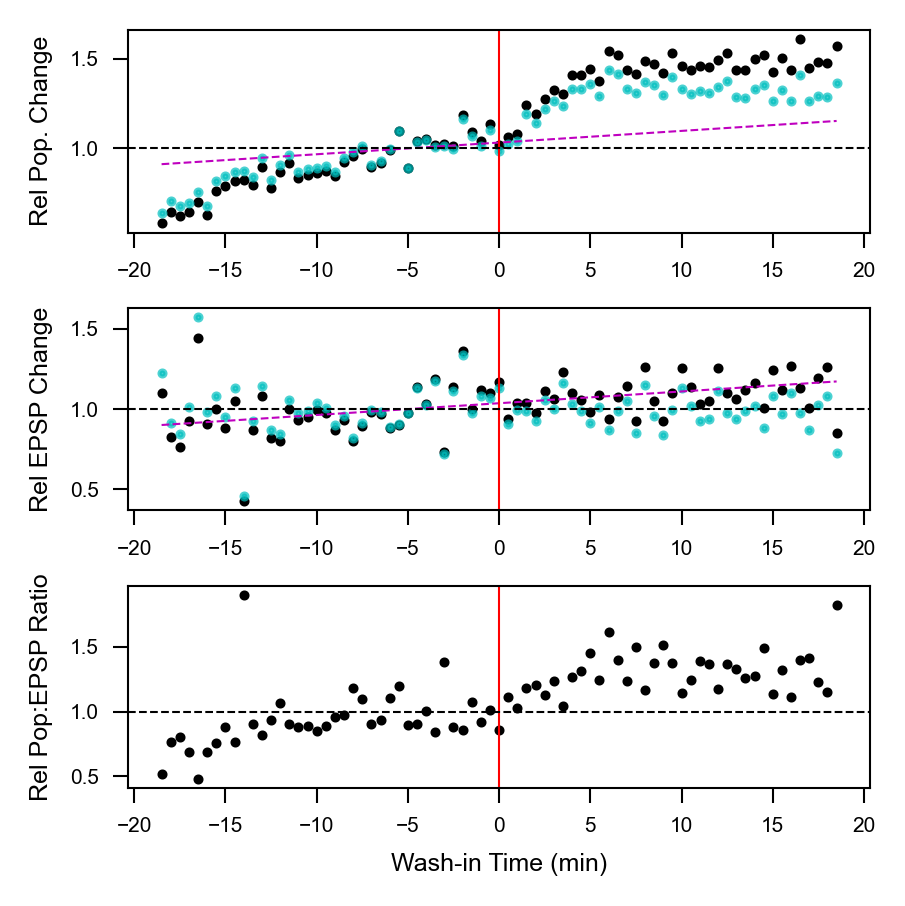

Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s004_0005.abf


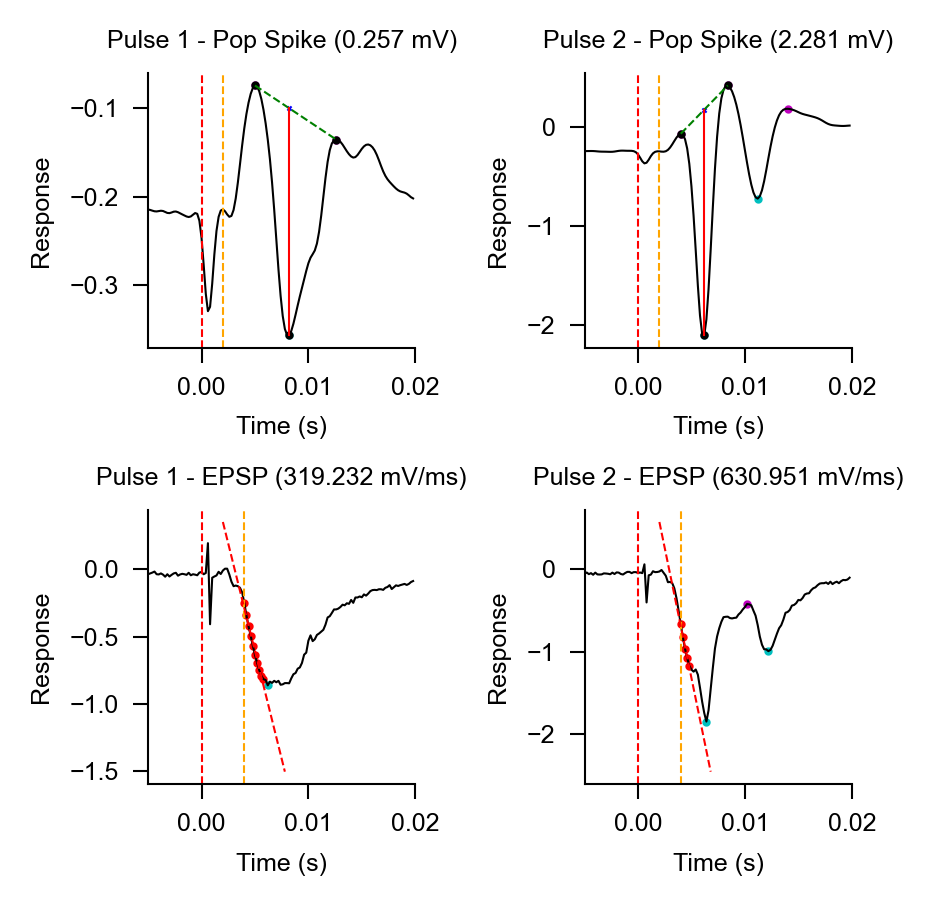

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s004_0006.abf


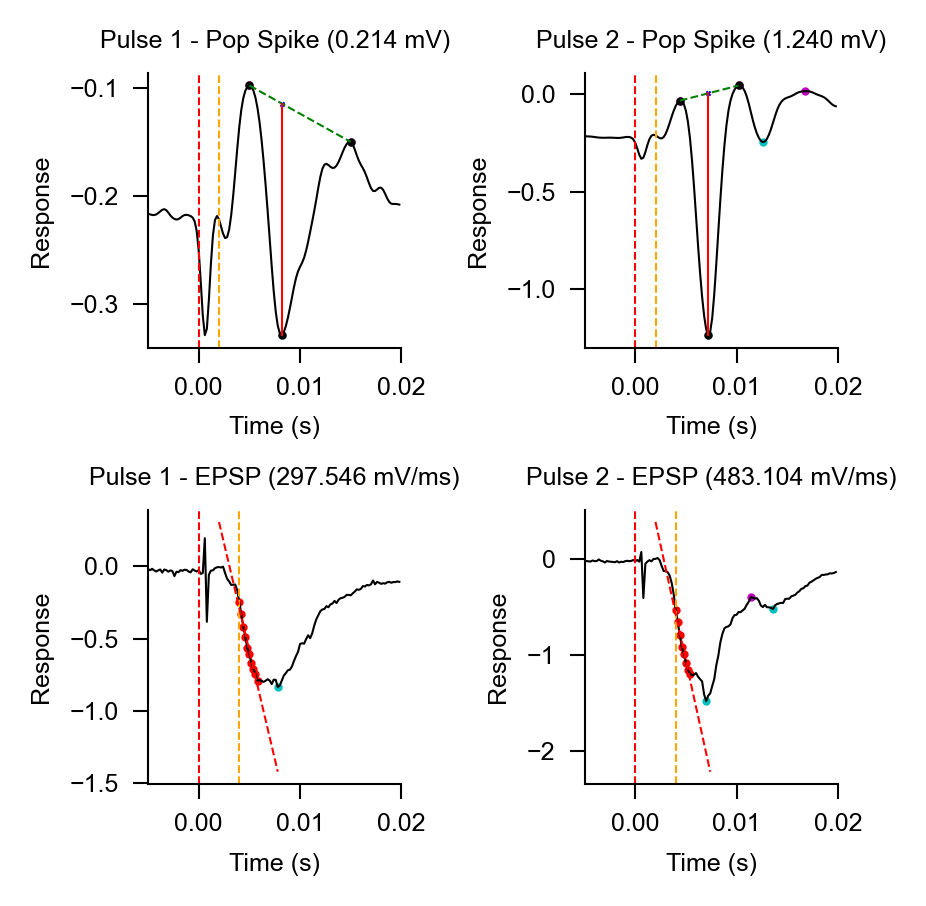

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s004_0007.abf


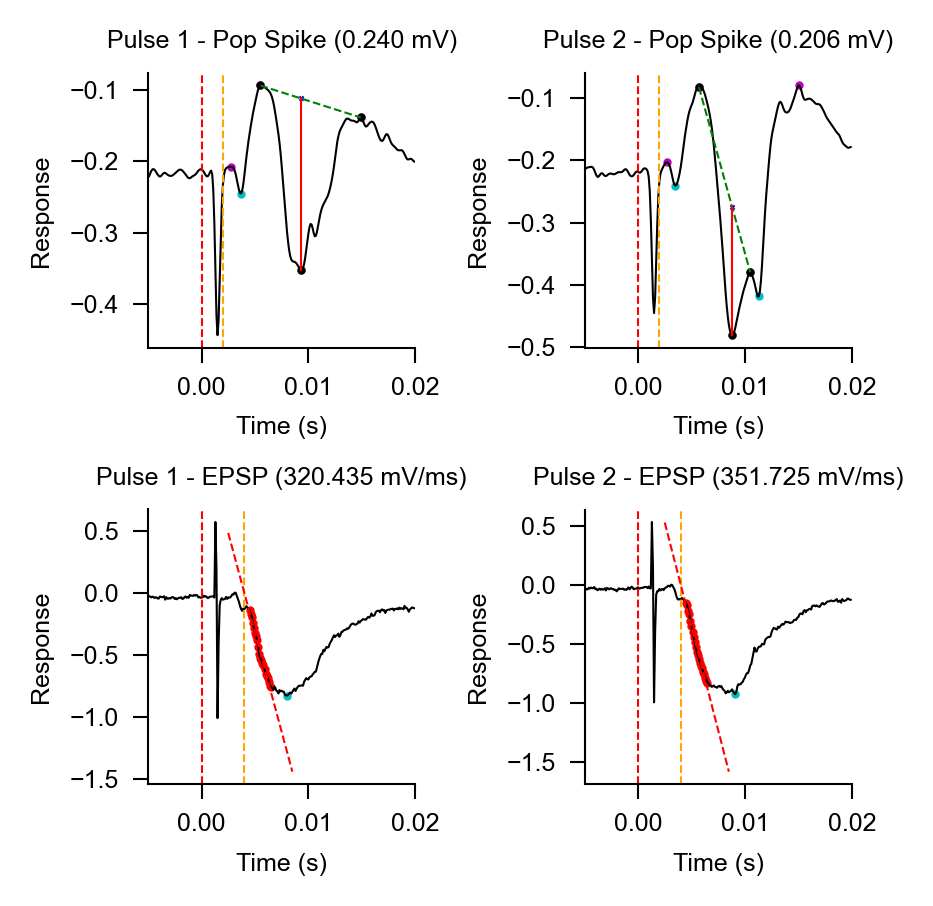

Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s004_0008.abf
Early termination: No sufficiently long contiguous regions found.
Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s005_0000.abf
No negative peaks detected
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s005_0001.abf
No negative peaks detected


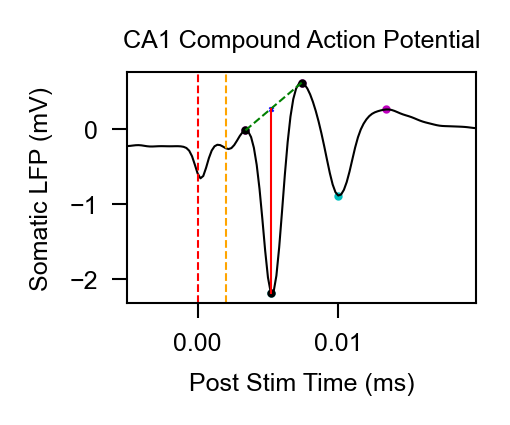

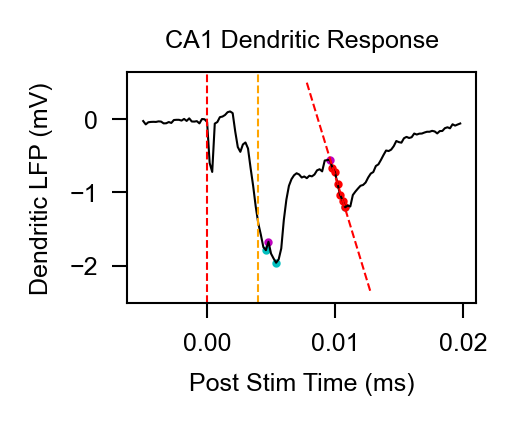

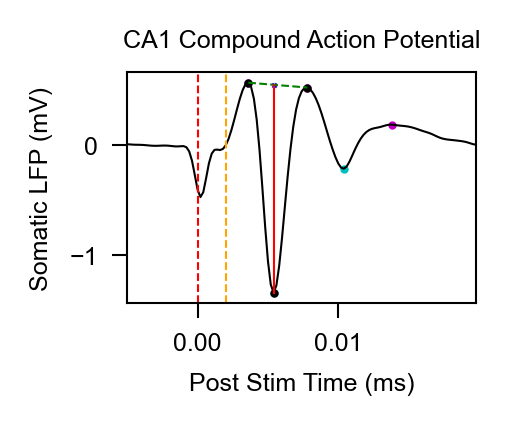

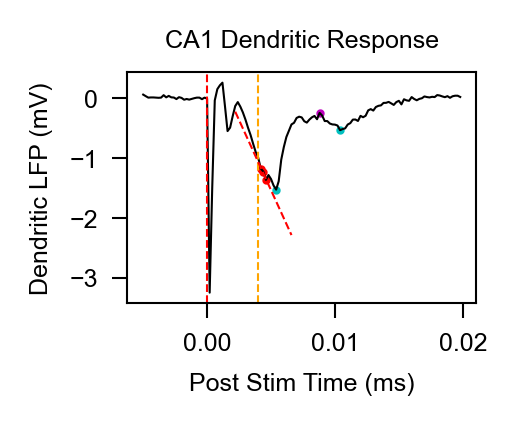

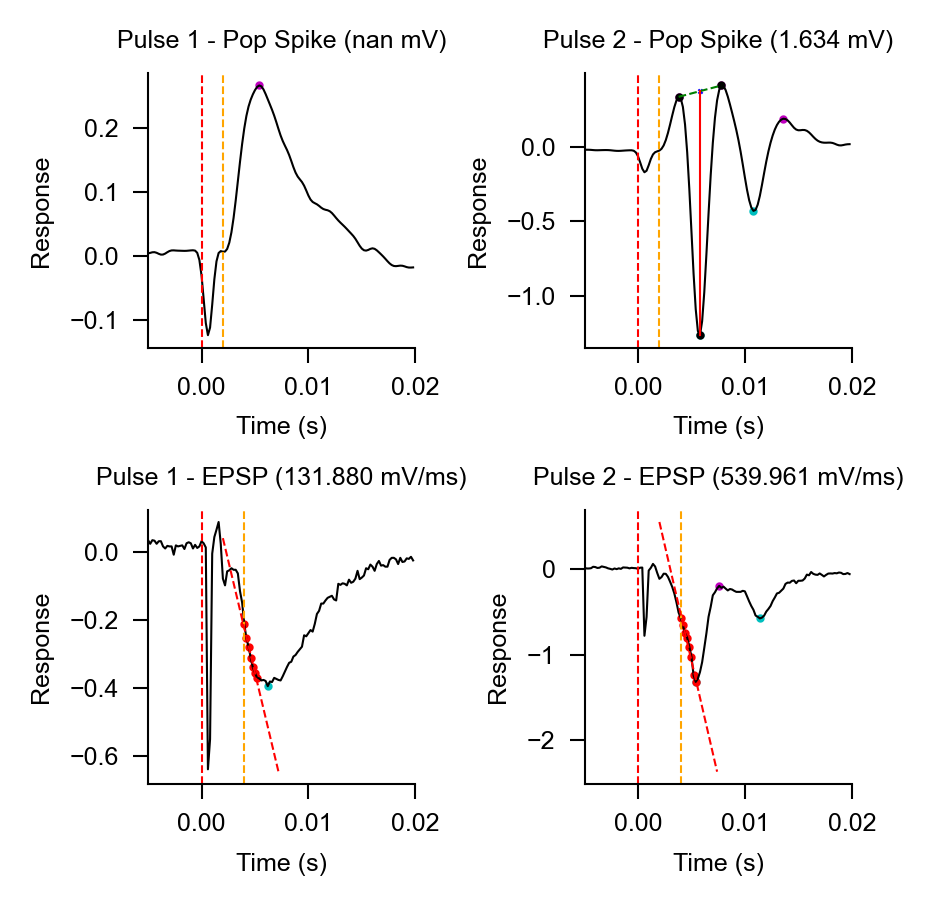

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s005_0002.abf
No negative peaks detected


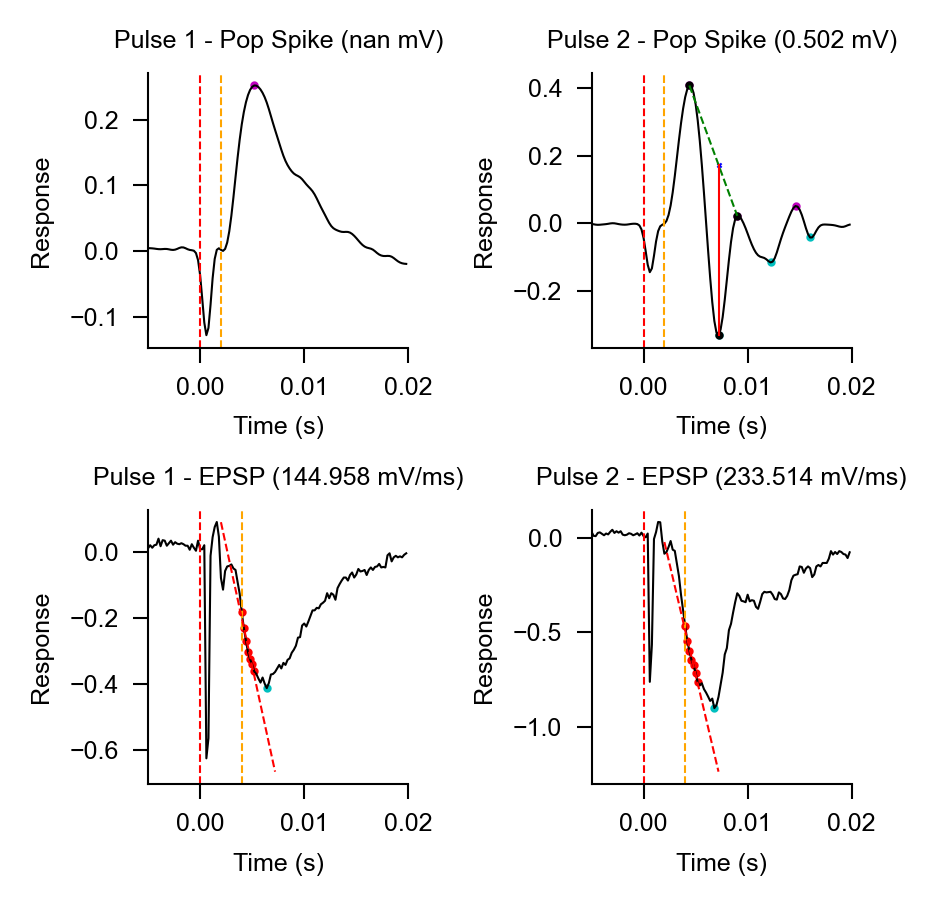

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s005_0003.abf


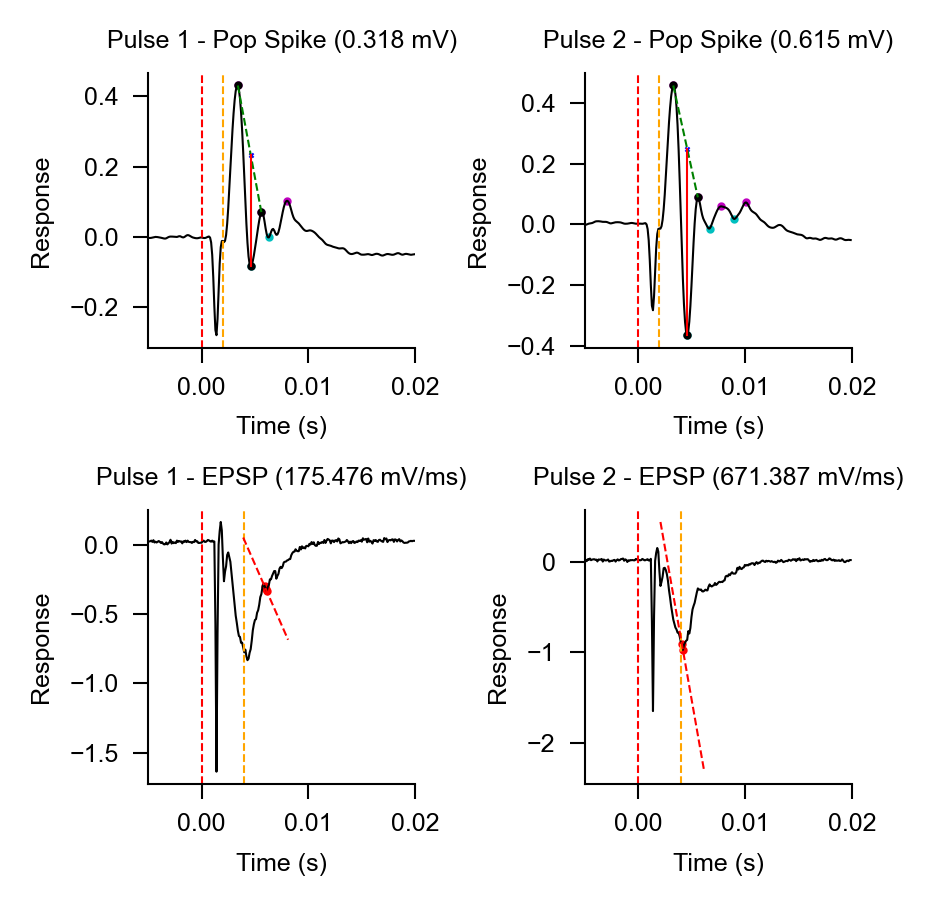

Applying Wash-In Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s005_0004.abf, Switch Time: 10.5 min


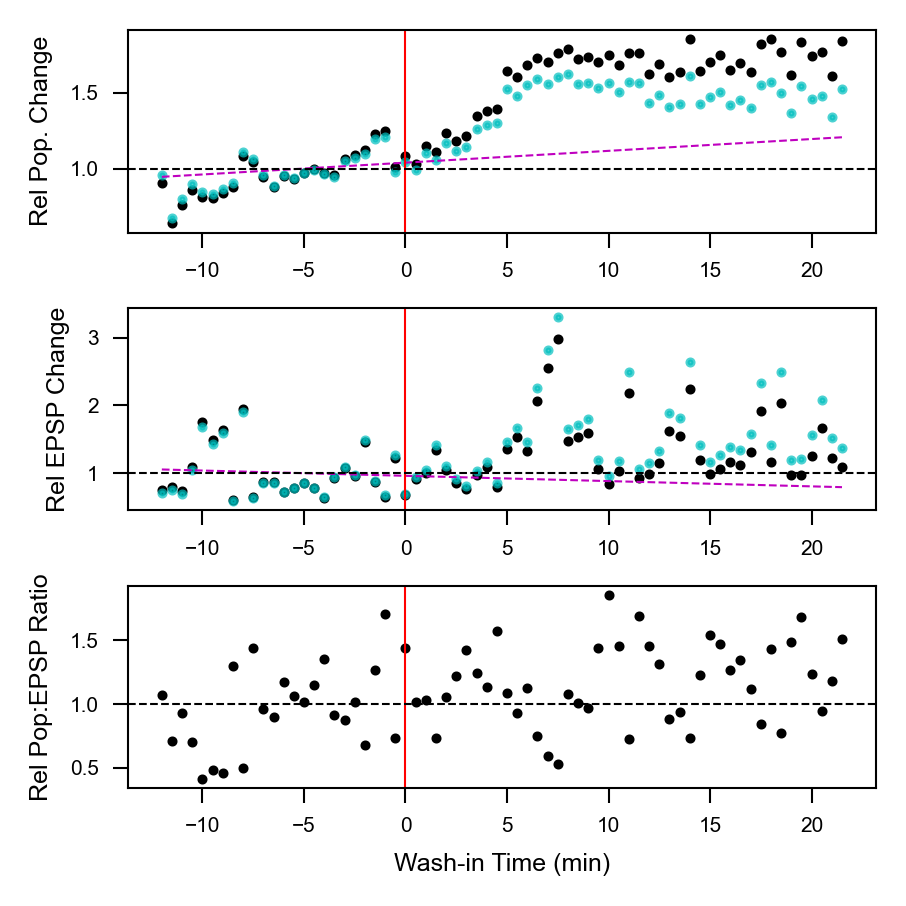

Applying Ramp Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s005_0005.abf
No flanking positive peaks found
Early termination: No sufficiently long contiguous regions found.
Applying PPR_50 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s005_0006.abf
No negative peaks detected


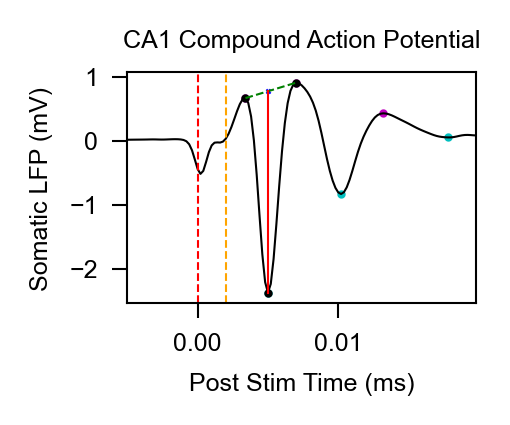

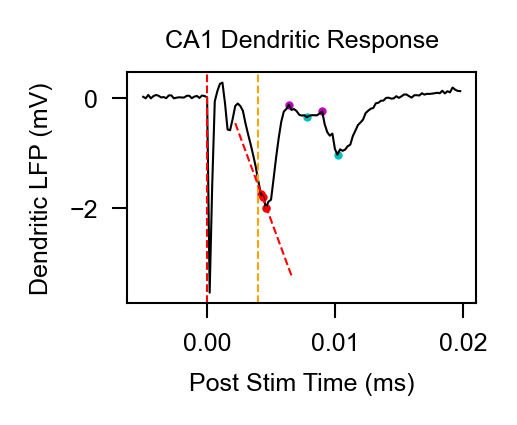

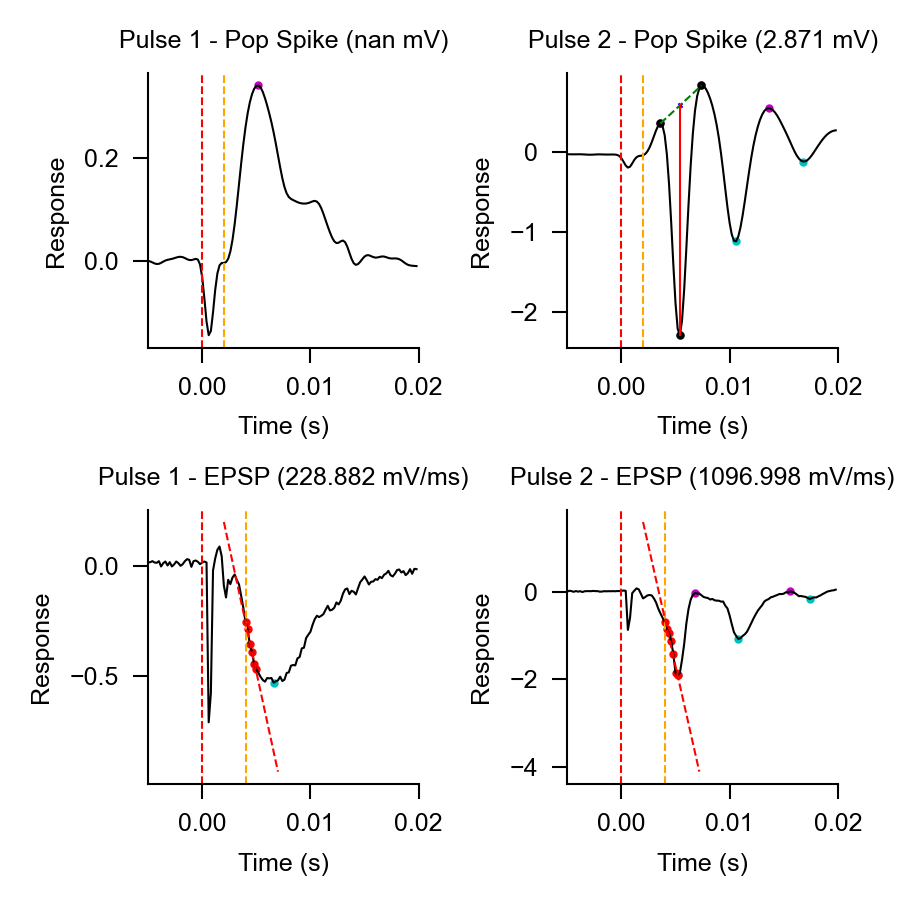

Applying PPR_100 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s005_0007.abf
No negative peaks detected


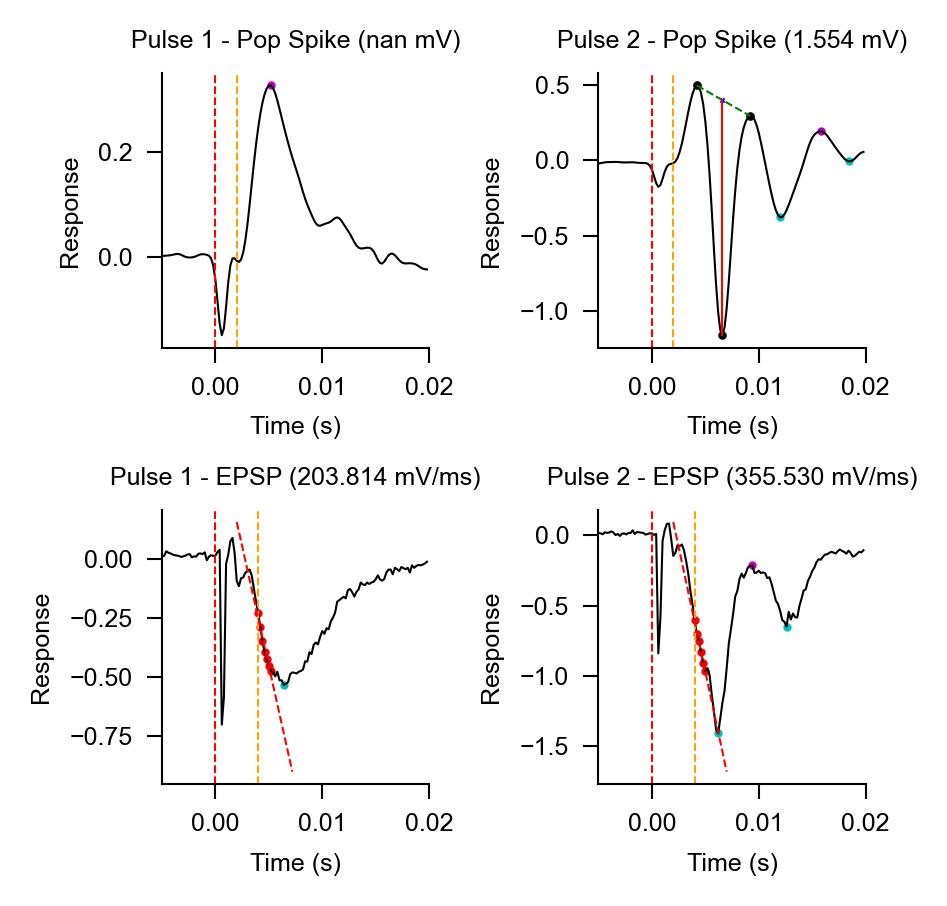

Applying PPR_1000 Analysis for C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs\2025x03x26\2025x03x26_E4KI_F_P163_sagi_s005_0008.abf


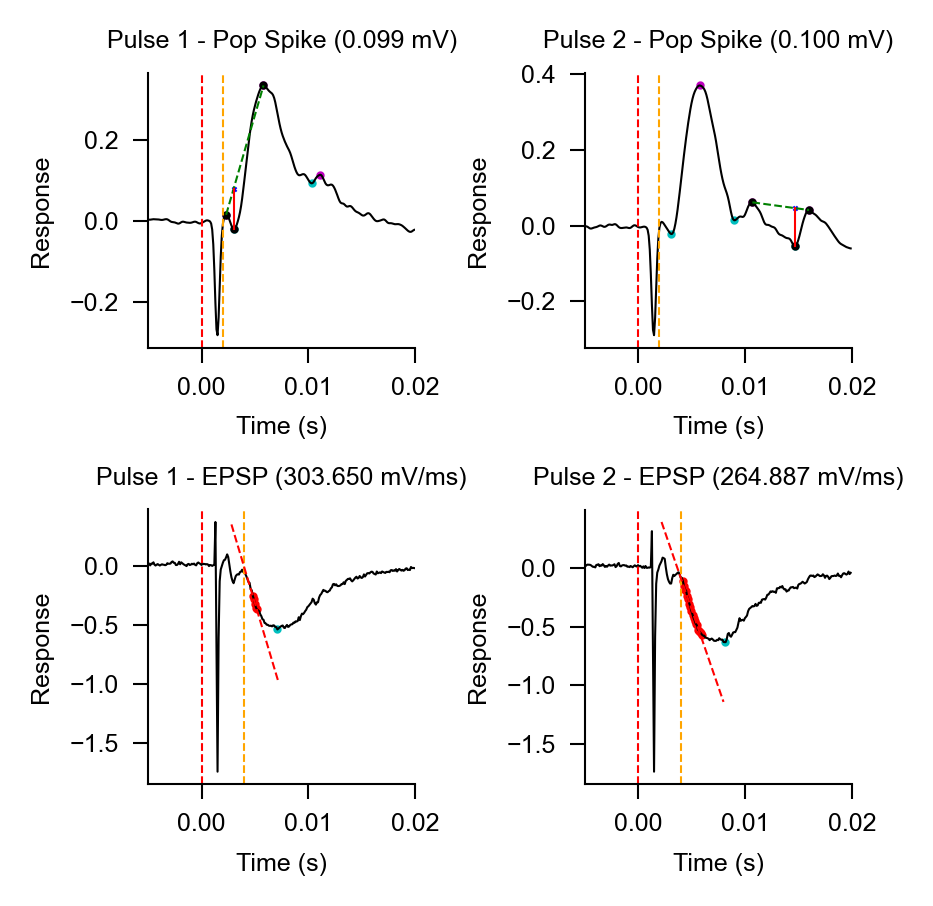

date genotype sex some_id description s_index abf_num  \
0   2025x03x21     E3KI   F    P160        sagi      S1    0000   
1   2025x03x21     E3KI   F    P160        sagi      S1    0001   
2   2025x03x21     E3KI   F    P160        sagi      S1    0002   
3   2025x03x21     E3KI   F    P160        sagi      S1    0003   
4   2025x03x21     E3KI   F    P160        sagi      S1    0004   
..         ...      ...  ..     ...         ...     ...     ...   
60  2025x03x26     E4KI   F    P163        sagi    s005    0004   
61  2025x03x26     E4KI   F    P163        sagi    s005    0005   
62  2025x03x26     E4KI   F    P163        sagi    s005    0006   
63  2025x03x26     E4KI   F    P163        sagi    s005    0007   
64  2025x03x26     E4KI   F    P163        sagi    s005    0008   

                                             abf_path       protocol  \
0   C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...           Ramp   
1   C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...         PPR_50   
2   C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...        PPR_100   
3   C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...       PPR_1000   
4   C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...  1per30s_Pulse   
..                                                ...            ...   
60  C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...  1per30s_Pulse   
61  C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...           Ramp   
62  C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...         PPR_50   
63  C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...        PPR_100   
64  C:\Users\dennis.tabuena\Gladstone Dropbox\Denn...       PPR_1000   

    sweepCount    Condition                        slice_code  \
0            9         None    2025x03x21_E3KI_F_P160_sagi_S1   
1            1         None    2025x03x21_E3KI_F_P160_sagi_S1   
2            1         None    2025x03x21_E3KI_F_P160_sagi_S1   
3            1         None    2025x03x21_E3KI_F_P160_sagi_S1   
4           75         None    2025x03x21_E3KI_F_P160_sagi_S1   
..         ...          ...                               ...   
60          68  10.5_OCD2HG  2025x03x26_E4KI_F_P163_sagi_s005   
61           9       OCD2HG  2025x03x26_E4KI_F_P163_sagi_s005   
62           1       OCD2HG  2025x03x26_E4KI_F_P163_sagi_s005   
63           1       OCD2HG  2025x03x26_E4KI_F_P163_sagi_s005   
64           1       OCD2HG  2025x03x26_E4KI_F_P163_sagi_s005   

                                              Results  
0   {'epsp_ramp_slope': 162.87394689636838, 'epsp_...  
1   {'pop': nan, 'epsp': 2.308300395256909, 'pop1'...  
2   {'pop': nan, 'epsp': 1.793016671909408, 'pop1'...  
3   {'pop': nan, 'epsp': 1.0185589519651745, 'pop1...  
4                                                None  
..                                                ...  
60  ({'final_pop_spike_fold_shift': 1.470691270704...  
61  {'epsp_ramp_slope': 327.5871228041164, 'epsp_v...  
62  {'pop': nan, 'epsp': 4.7928571428571844, 'pop1...  
63  {'pop': nan, 'epsp': 1.7443850267379828, 'pop1...  
64  {'pop': 1.0104834998179113, 'epsp': 0.87234417...  

[65 rows x 13 columns]

In [174]:

var_names = ['date','genotype','sex','age','orient','slice_num']
protocol_dict = {
    "PPR_50": analyze_paired_pulse,
    "PPR_100": analyze_paired_pulse,
    "PPR_1000": analyze_paired_pulse,
    "Ramp":         analyze_ramp,
    "1per30s_Pulse":      analyze_lfp_wash_in_rdc,
}

# Example usage:
my_dir = r"C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\_Colab_OutBox\For Yoshi\2HG\Recs"
os.chdir(my_dir)


all_abfs = find_abf_paths(my_dir)
print(all_abfs)
metadata_df = batch_collect_abf_metadata(all_abfs)
metadata_df = update_metadata_with_csv_values(metadata_df, note_book_csv)
# display(metadata_df)
analysis_dir = my_dir+ "./analysis"
os.makedirs(analysis_dir, exist_ok=True)
os.chdir(analysis_dir)
data_df = apply_protocol_analyses(metadata_df,protocol_dict)
display(data_df)


In [175]:
import pandas as pd

def restructure_protocol_data(df, condition_list):
    """
    Restructures the given DataFrame so that each protocol type has conditions as columns,
    indexed by slice_code, considering only specified conditions with fuzzy matching.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing protocol, condition, and results.
        condition_list (list): A list of condition keywords to include in the output.

    Returns:
        dict: A dictionary where keys are protocol types and values are the corresponding DataFrames.
    """
    # Filter rows where the Condition contains any of the specified keywords
    condition_mask = []
    for condition in df["Condition"].astype(str):
        matched = any(keyword in condition for keyword in condition_list)
        condition_mask.append(matched)

    df_filtered = df[condition_mask]

    # Get unique protocol types
    protocol_types = df_filtered["protocol"].unique()

    # Create dictionary to store DataFrames for each protocol
    protocol_dfs = {}

    for protocol in protocol_types:
        df_protocol = df_filtered[df_filtered["protocol"] == protocol]

        # Handle duplicates by aggregating (or taking the first occurrence)
        df_protocol = df_protocol.groupby(["slice_code", "Condition"], as_index=False).first()

        # Pivot the table so each condition becomes a column
        df_pivoted = df_protocol.pivot(index="slice_code", columns="Condition", values="Results")

        # Store the restructured DataFrame
        protocol_dfs[protocol] = df_pivoted

    return protocol_dfs

def flatten_dict(d, parent_key='', sep='_'):
    """
    Recursively flattens a nested dictionary.

    Parameters:
        d (dict): The dictionary to flatten.
        parent_key (str): The prefix for the keys (used for recursion).
        sep (str): Separator used for concatenated keys.

    Returns:
        dict: Flattened dictionary.
    """
    flattened = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            flattened.update(flatten_dict(v, new_key, sep=sep))
        else:
            flattened[new_key] = v
    return flattened





In [176]:
import pandas as pd

def convert_to_multiindex(df, condition_list):
    """
    Converts a DataFrame into a MultiIndexed format where:
    - Columns that match `condition_list` are elevated to MultiIndex levels.
    - All other columns are grouped under a `Metadata` super-column.

    Parameters:
        df (pd.DataFrame): The input DataFrame with metadata and condition-based data.
        condition_list (list): List of column names that should be treated as condition-based data.

    Returns:
        pd.DataFrame: A MultiIndexed DataFrame with structured metadata and condition columns.
    """

    # **Ensure slice_code is set as index**
    if "slice_code" in df.columns:
        df = df.set_index("slice_code")

    # **Identify metadata columns (anything not in condition_list)**
    metadata_cols = [col for col in df.columns if col not in condition_list]

    # **Reformat metadata by adding a new MultiIndex level under "Metadata"**
    metadata_df = df[metadata_cols].copy()
    metadata_df.columns = pd.MultiIndex.from_product([["Metadata"], metadata_cols])

    # **Reformat condition-related columns**
    condition_df = df[condition_list].copy()
    condition_df.columns = pd.MultiIndex.from_tuples([(col, "") for col in condition_df.columns])

    # **Concatenate both DataFrames**
    multiindex_df = pd.concat([metadata_df, condition_df], axis=1)

    return multiindex_df


In [177]:
import pandas as pd

def restructure_protocol_data(df, condition_list):
    """
    Restructures the given DataFrame so that each protocol type has conditions as columns,
    indexed by slice_code, while retaining all metadata.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing protocol, condition, results, and metadata.
        condition_list (list): A list of condition keywords to include in the output.

    Returns:
        dict: A dictionary where keys are protocol types and values are the corresponding DataFrames.
    """

    # Ensure slice_code is a string
    df["slice_code"] = df["slice_code"].astype(str)

    # Identify metadata columns (excluding protocol, condition, results)
    metadata_cols = [col for col in df.columns if col not in ["protocol", "Condition", "Results"]]

    # Create dictionary to store DataFrames for each protocol
    protocol_dfs = {}

    for protocol in df["protocol"].unique():
        # Extract only the relevant subset for this protocol
        df_protocol = df[df["protocol"] == protocol]

        # Filter only the relevant conditions for this protocol
        df_protocol = df_protocol[df_protocol["Condition"].astype(str).apply(
            lambda x: any(keyword in x for keyword in condition_list)
        )]

        # Pivot the table so each condition becomes a column
        pivoted_df = df_protocol.pivot(index="slice_code", columns="Condition", values="Results")

        # Deduplicate metadata and align with pivoted_df index
        metadata_df = (
            df[df["protocol"] == protocol]
            .drop(columns=["Condition", "Results"], errors="ignore")
            .drop_duplicates(subset=["slice_code"])
            .set_index("slice_code")
            .loc[pivoted_df.index]
        )

        # Store the structured DataFrame
        protocol_dfs[protocol] = pivoted_df.join(metadata_df, how="left")

    return protocol_dfs


In [178]:
import pandas as pd

def extract_keys_as_columns(df):
    """
    Extracts keys from nested dictionaries inside a single-column DataFrame
    and makes them new columns while preserving indices and adding a MultiIndex.

    Parameters:
        df (pd.DataFrame): DataFrame containing dictionaries in a single column.

    Returns:
        pd.DataFrame: DataFrame with extracted dictionary keys as new columns,
                      with the original column name as the MultiIndex level 0.
    """
    # Get the single column name
    column_name = df.columns[0]

    # Extract values from dictionaries while preserving row indices
    new_rows = [{**row} if isinstance(row, dict) else {} for row in df[column_name]]
    expanded_df = pd.DataFrame(new_rows, index=df.index)  # Maintain original indices

    # Set MultiIndex with the original column name as the top-level index
    expanded_df.columns = pd.MultiIndex.from_product([[column_name], expanded_df.columns])

    return expanded_df



In [179]:
import pandas as pd

def multi_index_conditions(protocol_df, columns):
    """
    Expands dictionary columns into separate columns with MultiIndex headers.

    Parameters:
        protocol_df (pd.DataFrame): The DataFrame containing multiple dictionary columns.
        columns (list): List of column names to expand.

    Returns:
        pd.DataFrame: Updated DataFrame with extracted keys as MultiIndex columns.
    """
    expanded_dfs = []  # Store expanded DataFrames

    for column in columns:
        if column in protocol_df.columns:
            expanded_df = extract_keys_as_columns(protocol_df[[column]])  # Extract as new DF
            expanded_dfs.append(expanded_df)  # Store for later merging

    # Merge all expanded data back into protocol_df
    if expanded_dfs:
        protocol_df = pd.concat([protocol_df] + expanded_dfs, axis=1)

    return protocol_df


In [188]:
condition_list = ['control', 'D2HG', "OCD2HG"]
protocol_dfs = restructure_protocol_data(data_df, condition_list)
for k,v in protocol_dfs.items():
    expanded = multi_index_conditions(v, condition_list)
    expanded = expanded.sort_values(by="genotype")
    expanded.to_csv(f'LFP_Shcaffer_Data_{k}.csv')


10.25_D2HG  \
slice_code                                                                            
2025x03x26_E4KI_F_P163_sagi_s001  ({'final_pop_spike_fold_shift': 1.056936083580...   
2025x03x26_E4KI_F_P163_sagi_s002                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s003                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s004                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s005                                                NaN   

                                                                        10.5_OCD2HG  \
slice_code                                                                            
2025x03x26_E4KI_F_P163_sagi_s001                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s002                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s003                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s004                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s005  ({'final_pop_spike_fold_shift': 1.470691270704...   

                                                                         14.75_D2HG  \
slice_code                                                                            
2025x03x26_E4KI_F_P163_sagi_s001                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s002  ({'final_pop_spike_fold_shift': 1.134313977298...   
2025x03x26_E4KI_F_P163_sagi_s003                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s004                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s005                                                NaN   

                                                                       16.25_OCD2HG  \
slice_code                                                                            
2025x03x26_E4KI_F_P163_sagi_s001                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s002                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s003  ({'final_pop_spike_fold_shift': 1.677432931849...   
2025x03x26_E4KI_F_P163_sagi_s004                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s005                                                NaN   

                                                                        17.0_OCD2HG  \
slice_code                                                                            
2025x03x26_E4KI_F_P163_sagi_s001                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s002                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s003                                                NaN   
2025x03x26_E4KI_F_P163_sagi_s004  ({'final_pop_spike_fold_shift': 1.313149368506...   
2025x03x26_E4KI_F_P163_sagi_s005                                                NaN   

                                        date genotype sex some_id description  \
slice_code                                                                      
2025x03x26_E4KI_F_P163_sagi_s001  2025x03x26     E4KI   F    P163        sagi   
2025x03x26_E4KI_F_P163_sagi_s002  2025x03x26     E4KI   F    P163        sagi   
2025x03x26_E4KI_F_P163_sagi_s003  2025x03x26     E4KI   F    P163        sagi   
2025x03x26_E4KI_F_P163_sagi_s004  2025x03x26     E4KI   F    P163        sagi   
2025x03x26_E4KI_F_P163_sagi_s005  2025x03x26     E4KI   F    P163        sagi   

                                 s_index abf_num  \
slice_code                                         
2025x03x26_E4KI_F_P163_sagi_s001    s001    0004   
2025x03x26_E4KI_F_P163_sagi_s002    s002    0004   
2025x03x26_E4KI_F_P163_sagi_s003    s003    0004   
2025x03x26_E4KI_F_P163_sagi_s004    s004    0004   
2025x03x26_E4KI_F_P163_sagi_s005    s005    0004   

                                                                           abf_path  \
sli